<a href="https://colab.research.google.com/github/tejas-parjane/Machine-learning--customer-segmentation/blob/main/ML_customer_segmentation_for_Personalized_marketing_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
print(f"Downloaded files to directory: {path}")

# 2. Define the exact file name and create the full path.
file_name = "marketing_campaign.csv"
full_file_path = os.path.join(path, file_name)
df = pd.read_csv(full_file_path, sep='\t')

Using Colab cache for faster access to the 'customer-personality-analysis' dataset.
Downloaded files to directory: /kaggle/input/customer-personality-analysis


##SECTION 1: COMPREHENSIVE DATA QUALITY & EDA


In [ ]:

import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("DATA QUALITY REPORT")
print("="*80)

# 1.1 Basic Information
print(f"\n Dataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")

# 1.2 Missing Values
print(f"\n Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing_Count'] > 0])

# 1.3 Duplicates
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows: {duplicates}")

# 1.4 Data Types
print(f"\n Data Types:")
print(df.dtypes.value_counts())

# 1.5 Outlier Detection Function
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 1.6 Check for outliers in key numeric columns
print(f"\n Outlier Detection:")
numeric_cols = ['Income', 'Year_Birth', 'Recency', 'MntWines', 'MntFruits',
                'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

for col in numeric_cols:
    if col in df.columns:
        outliers, lower, upper = detect_outliers_iqr(df, col)
        print(f"   {col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
        print(f"      Valid range: [{lower:.2f}, {upper:.2f}]")

# 1.7 Handle Income outliers (keep reasonable range)
income_outliers, income_lower, income_upper = detect_outliers_iqr(df, 'Income')
print(f"\n Income outliers detected: {len(income_outliers)}")
print(f"   Keeping values between ${income_lower:,.0f} and ${income_upper:,.0f}")

# Remove extreme outliers (optional - be careful)
# df = df[(df['Income'] >= income_lower) & (df['Income'] <= income_upper)]

# 1.8 Age validation (after Age feature is created later)
# We'll add this check after Age is created

print("\n" + "="*80)

DATA QUALITY REPORT

 Dataset Shape: (2240, 29)
   Rows: 2,240
   Columns: 29

 Missing Values:
        Missing_Count  Percentage
Income             24        1.07

 Duplicate Rows: 0

 Data Types:
int64      25
object      3
float64     1
Name: count, dtype: int64

 Outlier Detection:
   Income: 8 outliers (0.36%)
      Valid range: [-14525.50, 118350.50]
   Year_Birth: 3 outliers (0.13%)
      Valid range: [1932.00, 2004.00]
   Recency: 0 outliers (0.00%)
      Valid range: [-51.00, 149.00]
   MntWines: 35 outliers (1.56%)
      Valid range: [-697.00, 1225.00]
   MntFruits: 227 outliers (10.13%)
      Valid range: [-47.00, 81.00]
   MntMeatProducts: 175 outliers (7.81%)
      Valid range: [-308.00, 556.00]
   MntFishProducts: 223 outliers (9.96%)
      Valid range: [-67.50, 120.50]
   MntSweetProducts: 248 outliers (11.07%)
      Valid range: [-47.00, 81.00]
   MntGoldProds: 207 outliers (9.24%)
      Valid range: [-61.50, 126.50]

 Income outliers detected: 8
   Keeping values betwe

##SECTION 2: ADVANCED FEATURE ENGINEERING


In [ ]:

from datetime import datetime

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# 2.1 Remove non-predictive columns
columns_to_drop = ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']
existing_drops = [col for col in columns_to_drop if col in df.columns]
df.drop(existing_drops, axis=1, inplace=True)
print(f"\n Dropped columns: {existing_drops}")

# 2.2 Age (dynamic year)
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
df.drop('Year_Birth', axis=1, inplace=True)
print(f"\n Age feature created (current year: {current_year})")

# Validate age
invalid_ages = df[(df['Age'] < 18) | (df['Age'] > 100)]
if len(invalid_ages) > 0:
    print(f"    Warning: {len(invalid_ages)} customers with unusual ages")
    print(f"      Age range: {df['Age'].min()} to {df['Age'].max()}")

# 2.3 Customer Tenure
df['dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = pd.Timestamp(datetime.now())
df['Customer_Tenure'] = (reference_date - df['dt_Customer']).dt.days
df.drop(['Dt_Customer', 'dt_Customer'], axis=1, inplace=True, errors='ignore')
print(f"\n Customer Tenure created")
print(f"   Average tenure: {df['Customer_Tenure'].mean():.0f} days")

# 2.4 Education Encoding (Ordinal)
edu_map = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
df['Education_ord'] = df['Education'].map(edu_map)
print(f"\n Education encoded ordinally")
print(f"   Distribution:\n{df['Education'].value_counts()}")

# 2.5 Marital Status Simplification
df['Marital_Status_Simple'] = df['Marital_Status'].replace({
    'Married': 'Partner',
    'Together': 'Partner',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
})
print(f"\n Marital Status simplified")
print(f"   Distribution:\n{df['Marital_Status_Simple'].value_counts()}")

# 2.6 Spending Aggregation
spend_cols = [
    'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
]
df['Total_Spend'] = df[spend_cols].sum(axis=1)
print(f"\n Total Spend created")
print(f"   Mean: ${df['Total_Spend'].mean():.2f}")
print(f"   Median: ${df['Total_Spend'].median():.2f}")

# 2.7 Campaign Aggregation
cmp_cols = [
    'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
    'AcceptedCmp4', 'AcceptedCmp5', 'Response'
]
df['Total_Campaign_Accepted'] = df[cmp_cols].sum(axis=1)
print(f"\n Total Campaigns Accepted created")
print(f"   Mean: {df['Total_Campaign_Accepted'].mean():.2f}")
print(f"   Acceptance rate: {(df['Total_Campaign_Accepted'] > 0).mean()*100:.1f}%")

# 2.8 NEW: Advanced Interaction Features
print(f"\n Creating interaction features...")

# Total Children
df['Total_Children'] = df['Kidhome'] + df['Teenhome']

# Family Size
df['Has_Partner'] = (df['Marital_Status_Simple'] == 'Partner').astype(int)
df['Family_Size'] = df['Total_Children'] + df['Has_Partner'] + 1

# Total Purchases
purchase_cols = ['NumDealsPurchases', 'NumWebPurchases',
                 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)

# Spending per Purchase (avoid division by zero)
df['Spend_per_Purchase'] = df['Total_Spend'] / (df['Total_Purchases'] + 1)

# Income to Spend Ratio
df['Income_to_Spend_Ratio'] = df['Total_Spend'] / (df['Income'] + 1)

# Digital Engagement Score
df['Digital_Engagement'] = df['NumWebPurchases'] + df['NumWebVisitsMonth']

# Channel Preference
df['Store_vs_Web'] = df['NumStorePurchases'] / (df['NumWebPurchases'] + 1)

# Spending Diversity (how many categories they buy from)
df['Spending_Diversity'] = (df[spend_cols] > 0).sum(axis=1)

# Days per Purchase
df['Days_per_Purchase'] = df['Customer_Tenure'] / (df['Total_Purchases'] + 1)

# Campaign Response Rate
df['Campaign_Response_Rate'] = df['Total_Campaign_Accepted'] / 6.0  # 6 total campaigns

print(f"    Created {10} new interaction features")

# 2.9 Handle Missing Income (education-based median imputation)
if df['Income'].isnull().sum() > 0:
    print(f"\n Imputing {df['Income'].isnull().sum()} missing income values")
    df['Income'] = df.groupby('Education_ord')['Income'].transform(
        lambda x: x.fillna(x.median())
    )
    print(f"    Income imputation complete")

print("\n" + "="*80)

FEATURE ENGINEERING

 Dropped columns: ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']

 Age feature created (current year: 2025)
      Age range: 29 to 132

 Customer Tenure created
   Average tenure: 4547 days

 Education encoded ordinally
   Distribution:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

 Marital Status simplified
   Distribution:
Marital_Status_Simple
Partner    1444
Single      796
Name: count, dtype: int64

 Total Spend created
   Mean: $605.80
   Median: $396.00

 Total Campaigns Accepted created
   Mean: 0.45
   Acceptance rate: 27.2%

 Creating interaction features...
    Created 10 new interaction features

 Imputing 24 missing income values
    Income imputation complete



##SECTION 3: EXPLORATORY DATA ANALYSIS WITH VISUALIZATIONS


EXPLORATORY DATA ANALYSIS

 Key Statistics:
           Age     Income  Total_Spend  Total_Purchases  Customer_Tenure  \
count  2240.00    2240.00      2240.00          2240.00          2240.00   
mean     56.19   52242.59       605.80            14.86          4546.58   
std      11.98   25039.06       602.25             7.68           202.12   
min      29.00    1730.00         5.00             0.00          4193.00   
25%      48.00   35538.75        68.75             8.00          4373.75   
50%      55.00   51498.50       396.00            15.00          4548.50   
75%      66.00   68289.75      1045.50            21.00          4722.00   
max     132.00  666666.00      2525.00            44.00          4892.00   

       Total_Campaign_Accepted  
count                  2240.00  
mean                      0.45  
std                       0.89  
min                       0.00  
25%                       0.00  
50%                       0.00  
75%                       1.00  
max    

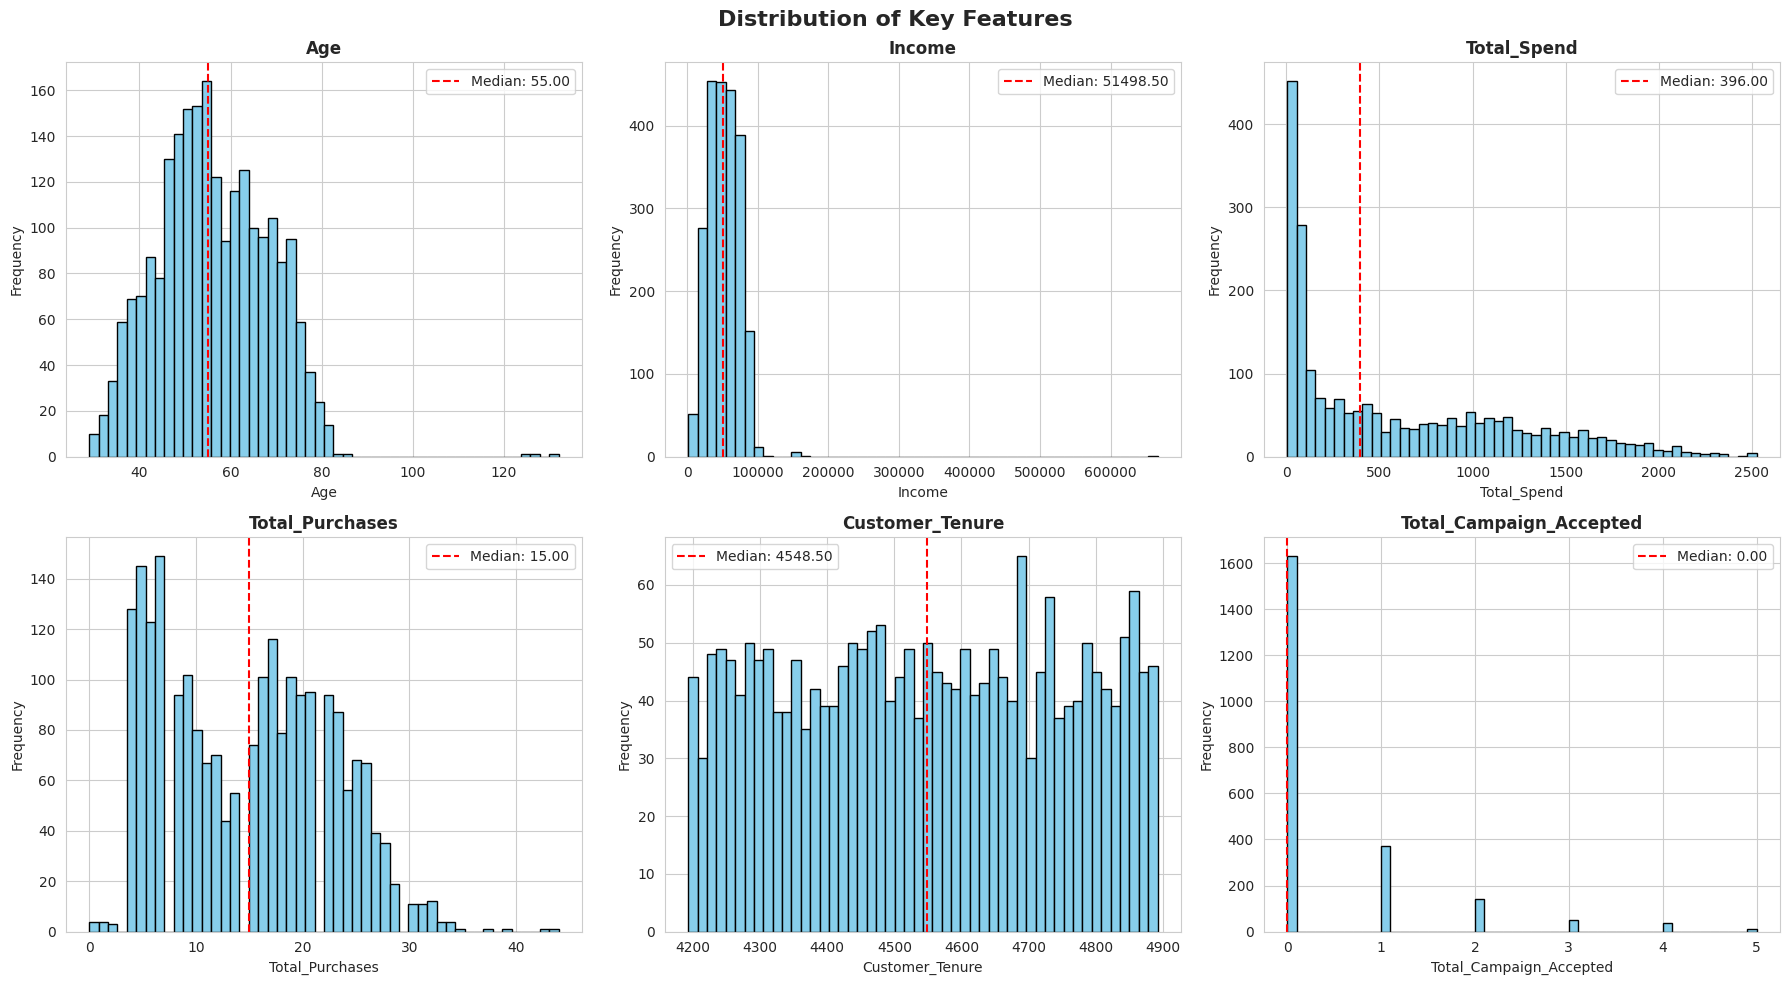

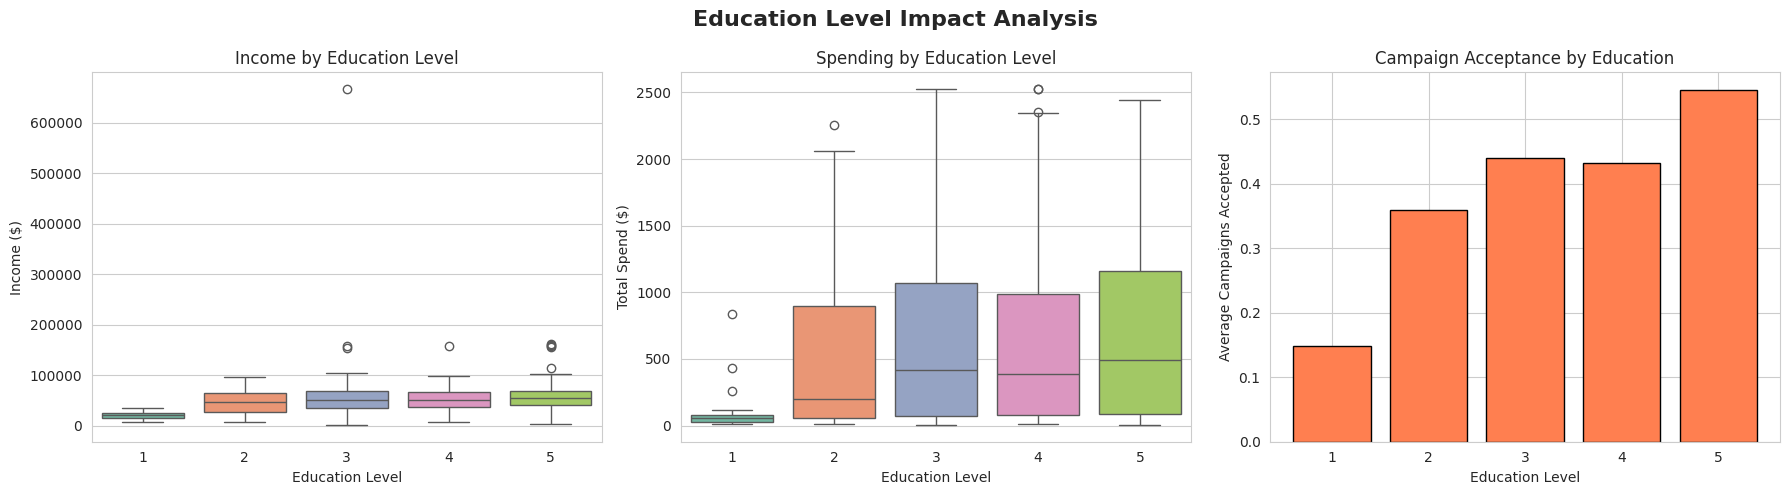


 Correlation Analysis:


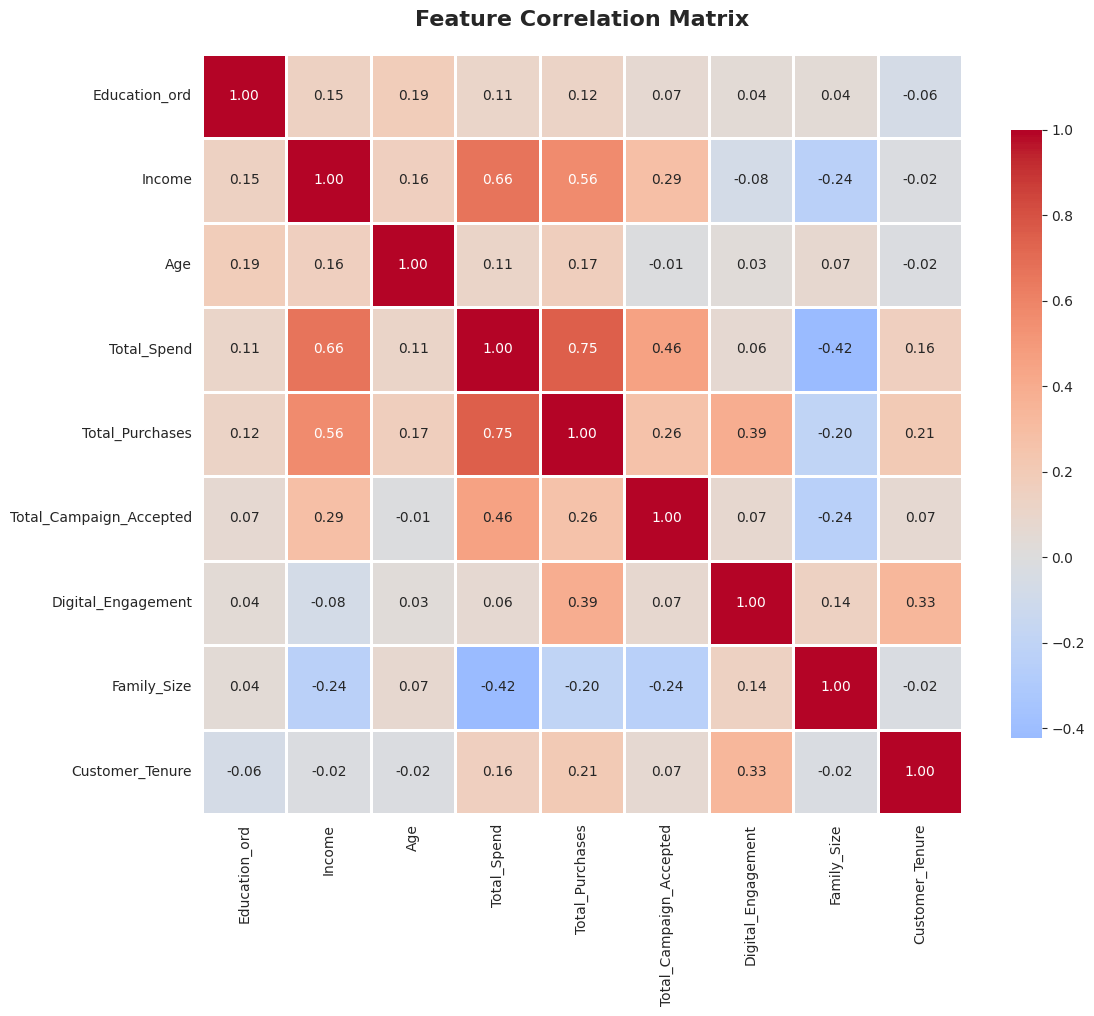


Top Correlations with Total_Spend:
Total_Purchases            0.753903
Income                     0.664503
Total_Campaign_Accepted    0.456206
Customer_Tenure            0.158814
Age                        0.111306
Name: Total_Spend, dtype: float64


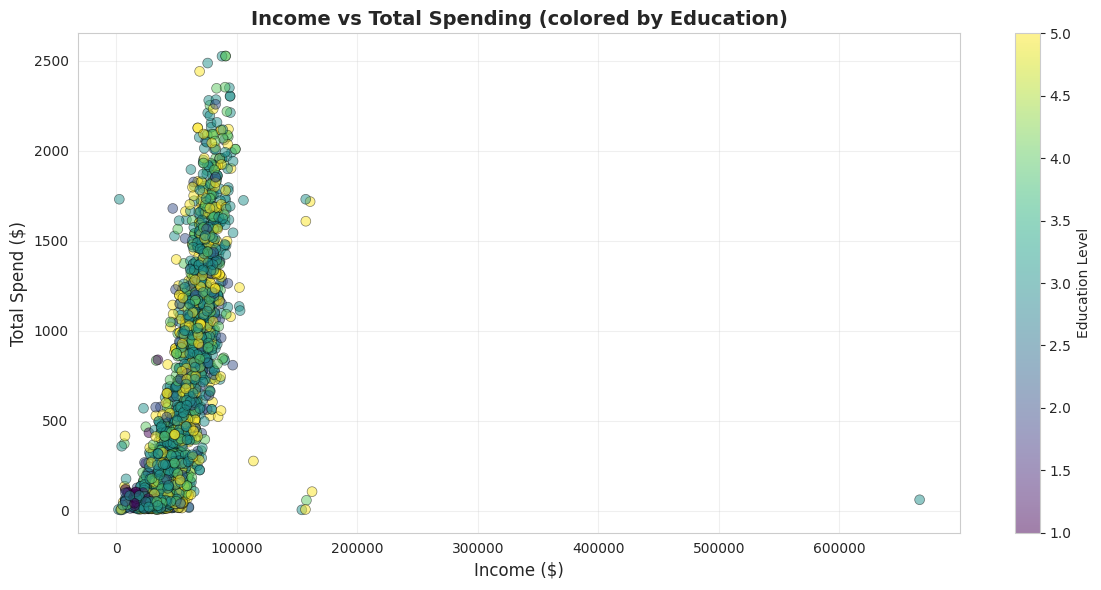

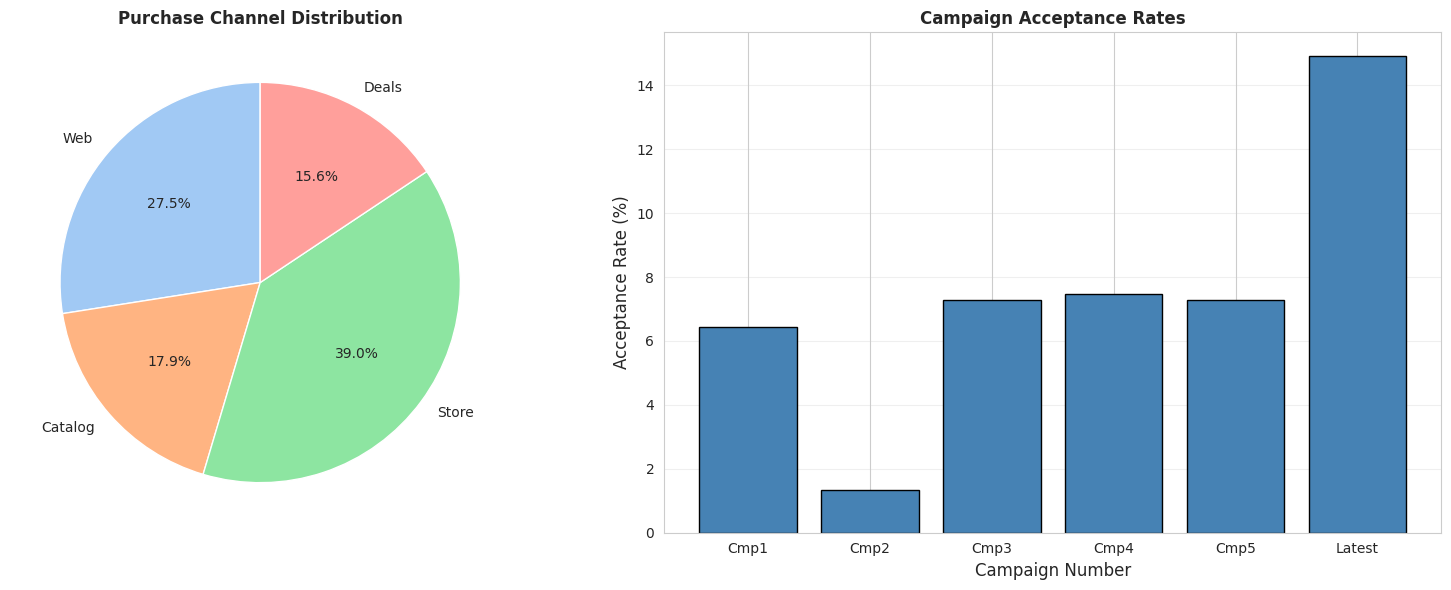

In [ ]:
# SECTION 3: EXPLORATORY DATA ANALYSIS WITH VISUALIZATIONS

import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 3.1 Descriptive Statistics
print("\n Key Statistics:")
key_features = ['Age', 'Income', 'Total_Spend', 'Total_Purchases',
                'Customer_Tenure', 'Total_Campaign_Accepted']
print(df[key_features].describe().round(2))

# 3.2 Distribution Plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Features', fontsize=16, fontweight='bold')

features_to_plot = ['Age', 'Income', 'Total_Spend',
                    'Total_Purchases', 'Customer_Tenure', 'Total_Campaign_Accepted']

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    df[feature].hist(bins=50, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f'{feature}', fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

    # Add median line
    median_val = df[feature].median()
    ax.axvline(median_val, color='red', linestyle='--',
               label=f'Median: {median_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

# 3.3 Education vs Key Metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Education Level Impact Analysis', fontsize=16, fontweight='bold')

# Education vs Income
sns.boxplot(x='Education_ord', y='Income', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Income by Education Level')
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Income ($)')

# Education vs Total Spend
sns.boxplot(x='Education_ord', y='Total_Spend', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Spending by Education Level')
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Total Spend ($)')

# Education vs Campaign Response
education_campaign = df.groupby('Education_ord')['Total_Campaign_Accepted'].mean()
axes[2].bar(education_campaign.index, education_campaign.values, color='coral', edgecolor='black')
axes[2].set_title('Campaign Acceptance by Education')
axes[2].set_xlabel('Education Level')
axes[2].set_ylabel('Average Campaigns Accepted')

plt.tight_layout()
plt.show()

# 3.4 Correlation Heatmap
print("\n Correlation Analysis:")
correlation_features = [
    'Education_ord', 'Income', 'Age', 'Total_Spend',
    'Total_Purchases', 'Total_Campaign_Accepted',
    'Digital_Engagement', 'Family_Size', 'Customer_Tenure'
]

plt.figure(figsize=(12, 10))
correlation_matrix = df[correlation_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True,
            linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print top correlations with Total_Spend
print("\nTop Correlations with Total_Spend:")
spend_corr = correlation_matrix['Total_Spend'].sort_values(ascending=False)
print(spend_corr[1:6])  # Exclude self-correlation

# 3.5 Income vs Spending Scatter
plt.figure(figsize=(12, 6))
plt.scatter(df['Income'], df['Total_Spend'], alpha=0.5, c=df['Education_ord'],
            cmap='viridis', s=50, edgecolors='black', linewidth=0.5)
plt.colorbar(label='Education Level')
plt.xlabel('Income ($)', fontsize=12)
plt.ylabel('Total Spend ($)', fontsize=12)
plt.title('Income vs Total Spending (colored by Education)',
          fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3.6 Channel Preference Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Purchase channel distribution
channel_data = df[['NumWebPurchases', 'NumCatalogPurchases',
                    'NumStorePurchases', 'NumDealsPurchases']].sum()
axes[0].pie(channel_data, labels=['Web', 'Catalog', 'Store', 'Deals'],
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
axes[0].set_title('Purchase Channel Distribution', fontweight='bold')

# Campaign acceptance over time
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
campaign_rates = df[campaign_cols].mean() * 100
axes[1].bar(range(1, 7), campaign_rates, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Campaign Number', fontsize=12)
axes[1].set_ylabel('Acceptance Rate (%)', fontsize=12)
axes[1].set_title('Campaign Acceptance Rates', fontweight='bold')
axes[1].set_xticks(range(1, 7))
axes[1].set_xticklabels(['Cmp1', 'Cmp2', 'Cmp3', 'Cmp4', 'Cmp5', 'Latest'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

##SECTION 4: ADVANCED CLUSTERING MODEL DEVELOPMENT


CLUSTERING MODEL DEVELOPMENT

 Selected 18 features for clustering
   Features: ['Education_ord', 'Income', 'Age', 'Customer_Tenure', 'Recency', 'Total_Spend', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome', 'Total_Campaign_Accepted', 'Family_Size', 'Digital_Engagement', 'Spend_per_Purchase', 'Total_Purchases']

 Features scaled using StandardScaler

 Evaluating optimal number of clusters (k=2 to k=10)...

Clustering Evaluation Metrics:
    k    inertia  silhouette  calinski_harabasz  davies_bouldin
0   2  30070.635       0.246            762.807           1.623
1   3  25965.815       0.228            618.319           1.694
2   4  24201.044       0.166            496.427           1.914
3   5  22951.309       0.160            422.841           1.950
4   6  21851.017       0.158            377.646           1.979
5   7  20999.845       0.151            342.399           1.924
6   8  20315.008       0.143   

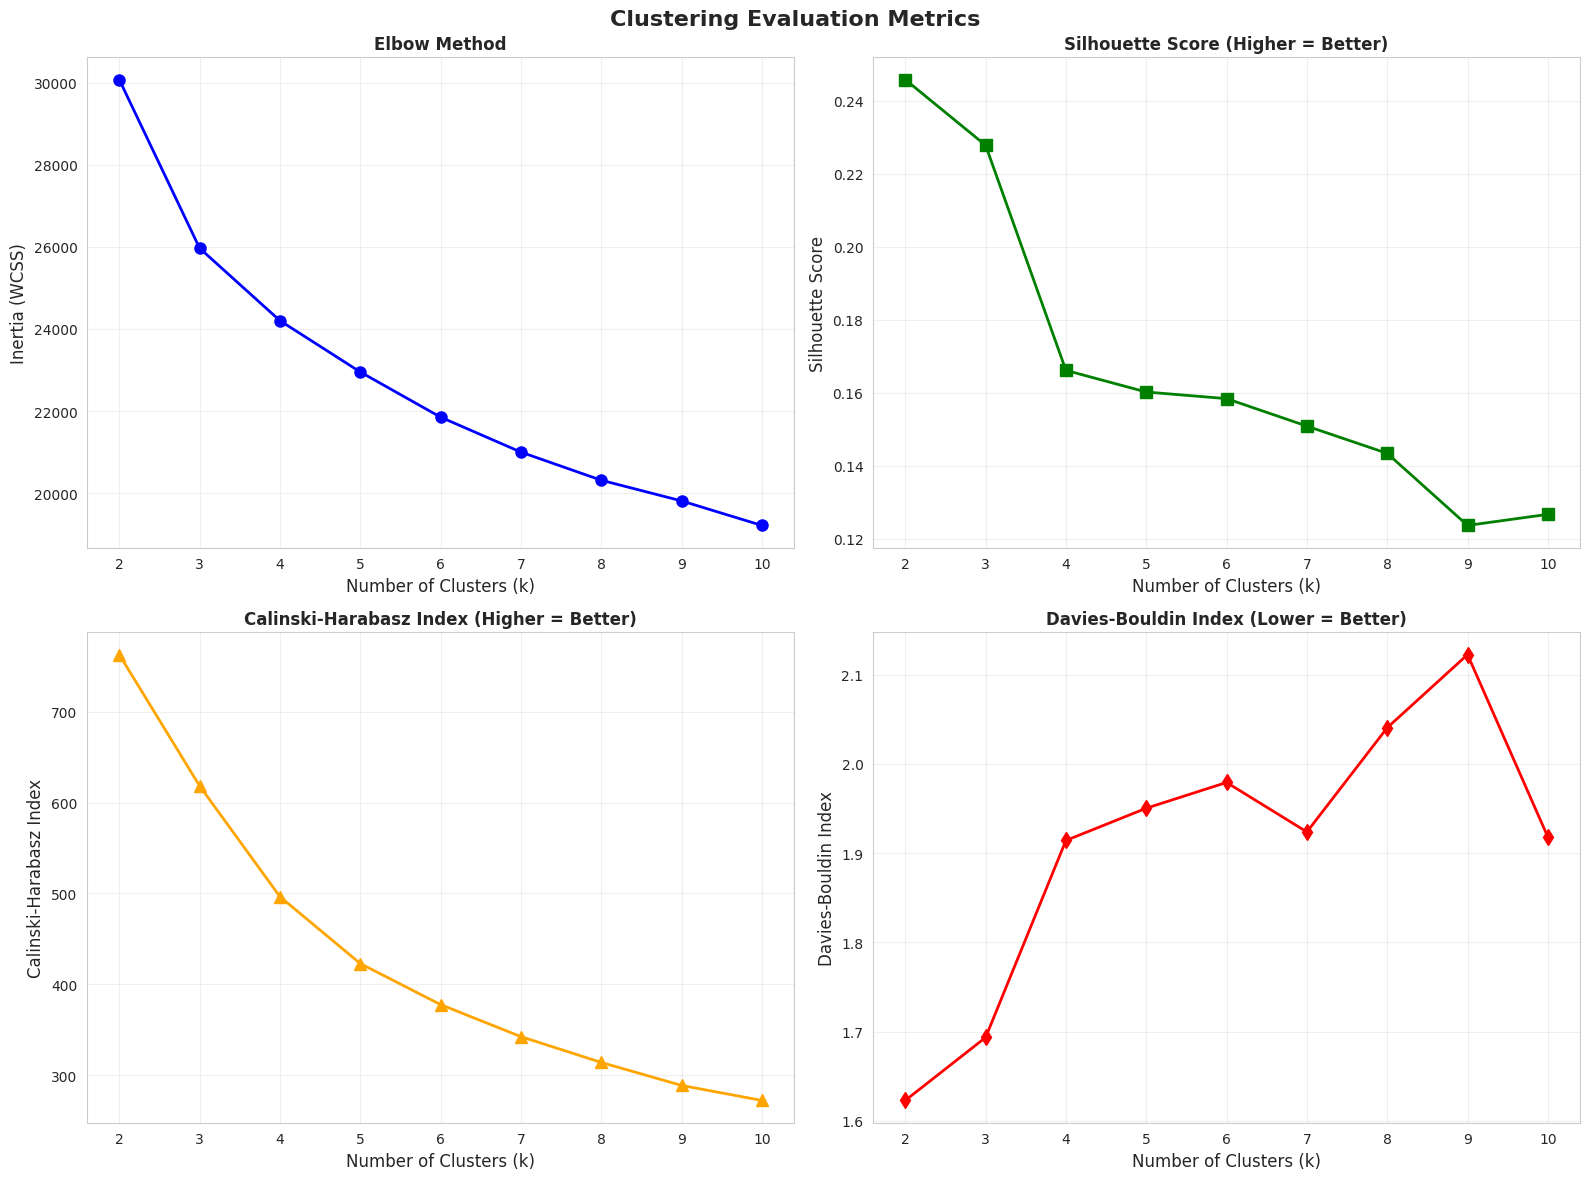


 Selected optimal k = 4
   Rationale: Balance between metrics and business interpretability

 Training final K-Means model with k=4...

 Final Model Performance:
   Silhouette Score: 0.1661
   Calinski-Harabasz: 496.43
   Davies-Bouldin: 1.9149

 Cluster Distribution:
   Cluster 0: 519 customers (23.2%)
   Cluster 1: 583 customers (26.0%)
   Cluster 2: 624 customers (27.9%)
   Cluster 3: 514 customers (22.9%)


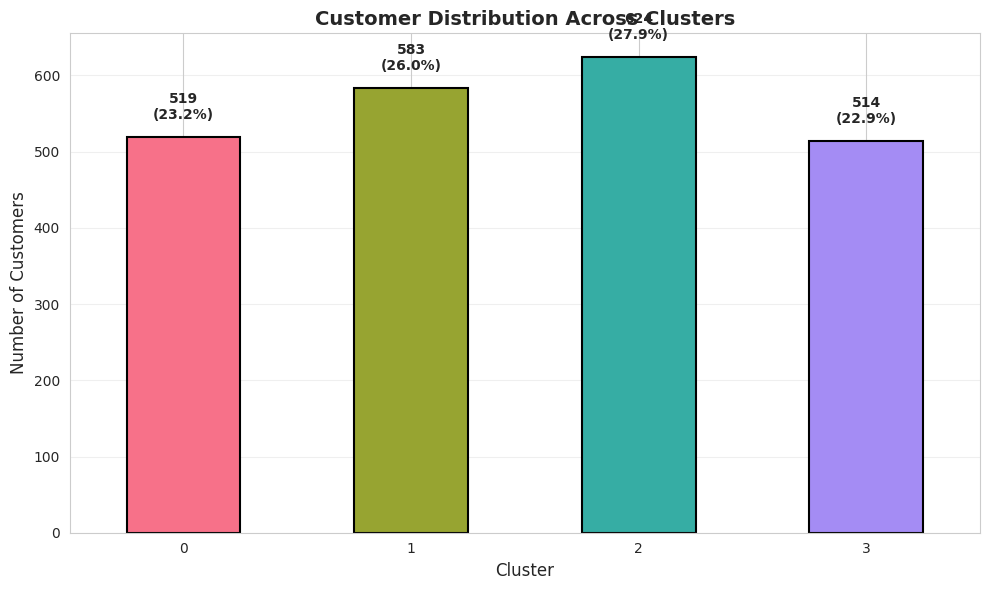


 Saving model artifacts...
    Model saved to 'models/kmeans_model.pkl'
    Scaler saved to 'models/scaler.pkl'
    Metadata saved to 'models/model_metadata.json'



In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
import os

print("="*80)
print("CLUSTERING MODEL DEVELOPMENT")
print("="*80)

# 4.1 Feature Selection for Clustering
cluster_features = [
    'Education_ord',
    'Income',
    'Age',
    'Customer_Tenure',
    'Recency',
    'Total_Spend',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumDealsPurchases',
    'NumWebVisitsMonth',
    'Kidhome',
    'Teenhome',
    'Total_Campaign_Accepted',
    'Family_Size',
    'Digital_Engagement',
    'Spend_per_Purchase',
    'Total_Purchases'
]

# Ensure all features exist
cluster_features = [f for f in cluster_features if f in df.columns]

X = df[cluster_features].copy()
print(f"\n Selected {len(cluster_features)} features for clustering")
print(f"   Features: {cluster_features}")

# 4.2 Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\n Features scaled using StandardScaler")

# 4.3 Determine Optimal Number of Clusters
print(f"\n Evaluating optimal number of clusters (k=2 to k=10)...")

k_range = range(2, 11)
metrics = {
    'k': [],
    'inertia': [],
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    metrics['k'].append(k)
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_scaled, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_scaled, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_scaled, labels))

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics)
print("\nClustering Evaluation Metrics:")
print(metrics_df.round(3))

# 4.4 Visualize Elbow Curve and Metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Clustering Evaluation Metrics', fontsize=16, fontweight='bold')

# Elbow Curve (Inertia)
axes[0, 0].plot(metrics_df['k'], metrics_df['inertia'], marker='o',
                linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Silhouette Score (Higher is better)
axes[0, 1].plot(metrics_df['k'], metrics_df['silhouette'], marker='s',
                linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Calinski-Harabasz Index (Higher is better)
axes[1, 0].plot(metrics_df['k'], metrics_df['calinski_harabasz'], marker='^',
                linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Index (Higher = Better)', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Davies-Bouldin Index (Lower is better)
axes[1, 1].plot(metrics_df['k'], metrics_df['davies_bouldin'], marker='d',
                linewidth=2, markersize=8, color='red')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Index (Lower = Better)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 4.5 Select Optimal k
optimal_k = 4  # Based on your analysis
print(f"\n Selected optimal k = {optimal_k}")
print(f"   Rationale: Balance between metrics and business interpretability")

# 4.6 Train Final Model
print(f"\n Training final K-Means model with k={optimal_k}...")
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
df['Cluster'] = final_kmeans.fit_predict(X_scaled)

# Calculate final metrics
final_silhouette = silhouette_score(X_scaled, df['Cluster'])
final_ch = calinski_harabasz_score(X_scaled, df['Cluster'])
final_db = davies_bouldin_score(X_scaled, df['Cluster'])

print(f"\n Final Model Performance:")
print(f"   Silhouette Score: {final_silhouette:.4f}")
print(f"   Calinski-Harabasz: {final_ch:.2f}")
print(f"   Davies-Bouldin: {final_db:.4f}")

# 4.7 Cluster Distribution
print(f"\n Cluster Distribution:")
cluster_dist = df['Cluster'].value_counts().sort_index()
for cluster_id in cluster_dist.index:
    count = cluster_dist[cluster_id]
    pct = count / len(df) * 100
    print(f"   Cluster {cluster_id}: {count:,} customers ({pct:.1f}%)")

# Visualize cluster distribution
plt.figure(figsize=(10, 6))
cluster_dist.plot(kind='bar', color=sns.color_palette('husl', optimal_k),
                  edgecolor='black', linewidth=1.5)
plt.title('Customer Distribution Across Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(cluster_dist):
    plt.text(i, v + 20, f'{v:,}\n({v/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# 4.8 Save Model Artifacts
print(f"\n Saving model artifacts...")

# Create models directory
os.makedirs('models', exist_ok=True)

# Save model
joblib.dump(final_kmeans, 'models/kmeans_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

# Save feature names
import json
model_metadata = {
    'n_clusters': optimal_k,
    'feature_names': cluster_features,
    'metrics': {
        'silhouette': float(final_silhouette),
        'calinski_harabasz': float(final_ch),
        'davies_bouldin': float(final_db)
    },
    'cluster_distribution': cluster_dist.to_dict(),
    'training_date': datetime.now().isoformat()
}

with open('models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=4)

print(f"    Model saved to 'models/kmeans_model.pkl'")
print(f"    Scaler saved to 'models/scaler.pkl'")
print(f"    Metadata saved to 'models/model_metadata.json'")

print("\n" + "="*80)

##SECTION 5: CLUSTER VISUALIZATION & INTERPRETATION


CLUSTER VISUALIZATION & ANALYSIS

 Performing PCA for 2D visualization...
 Performing t-SNE for 2D visualization (this may take a minute)...


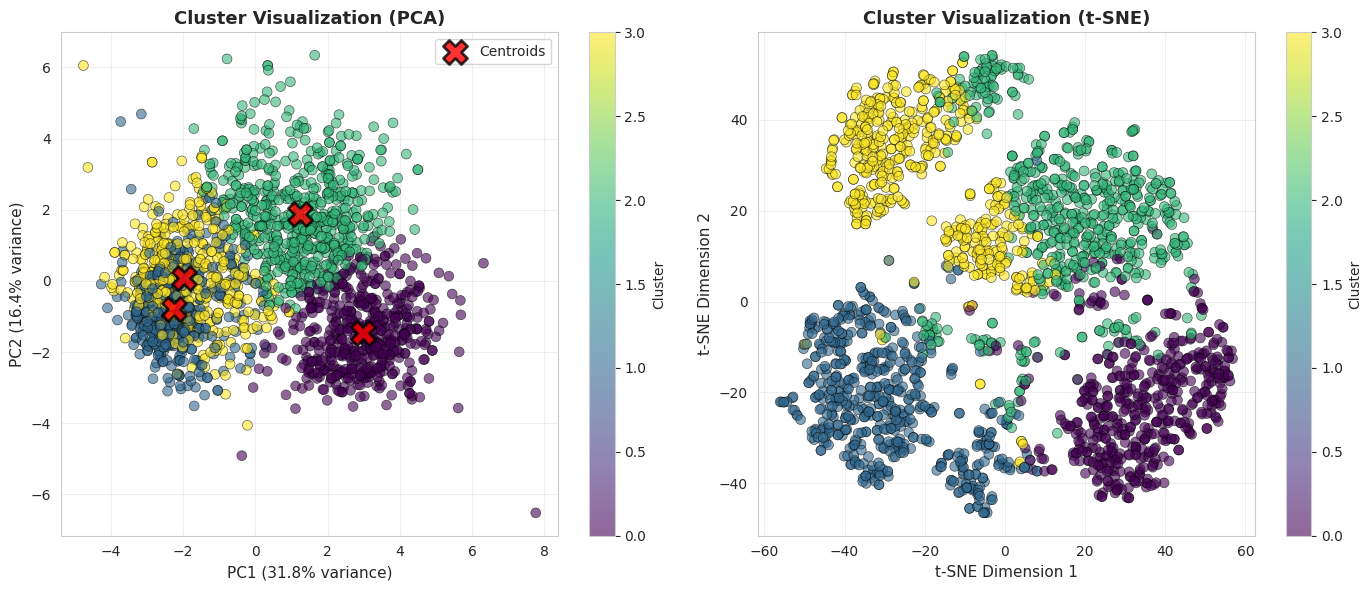


📋 Detailed Cluster Profiles:
         Education_ord    Income    Age  Total_Spend  NumWebPurchases  \
Cluster                                                                 
0                 3.53  77659.58  56.98      1382.00             4.62   
1                 3.11  29526.87  47.76        97.14             2.16   
2                 3.61  59597.51  59.36       829.89             6.97   
3                 3.60  43414.56  61.12       126.94             2.23   

         NumStorePurchases  NumCatalogPurchases  Total_Campaign_Accepted  \
Cluster                                                                    
0                     8.10                 6.06                     1.09   
1                     3.11                 0.51                     0.21   
2                     8.10                 3.42                     0.40   
3                     3.68                 0.75                     0.12   

         Digital_Engagement  Family_Size  Customer_Tenure  Spend_per_Purch

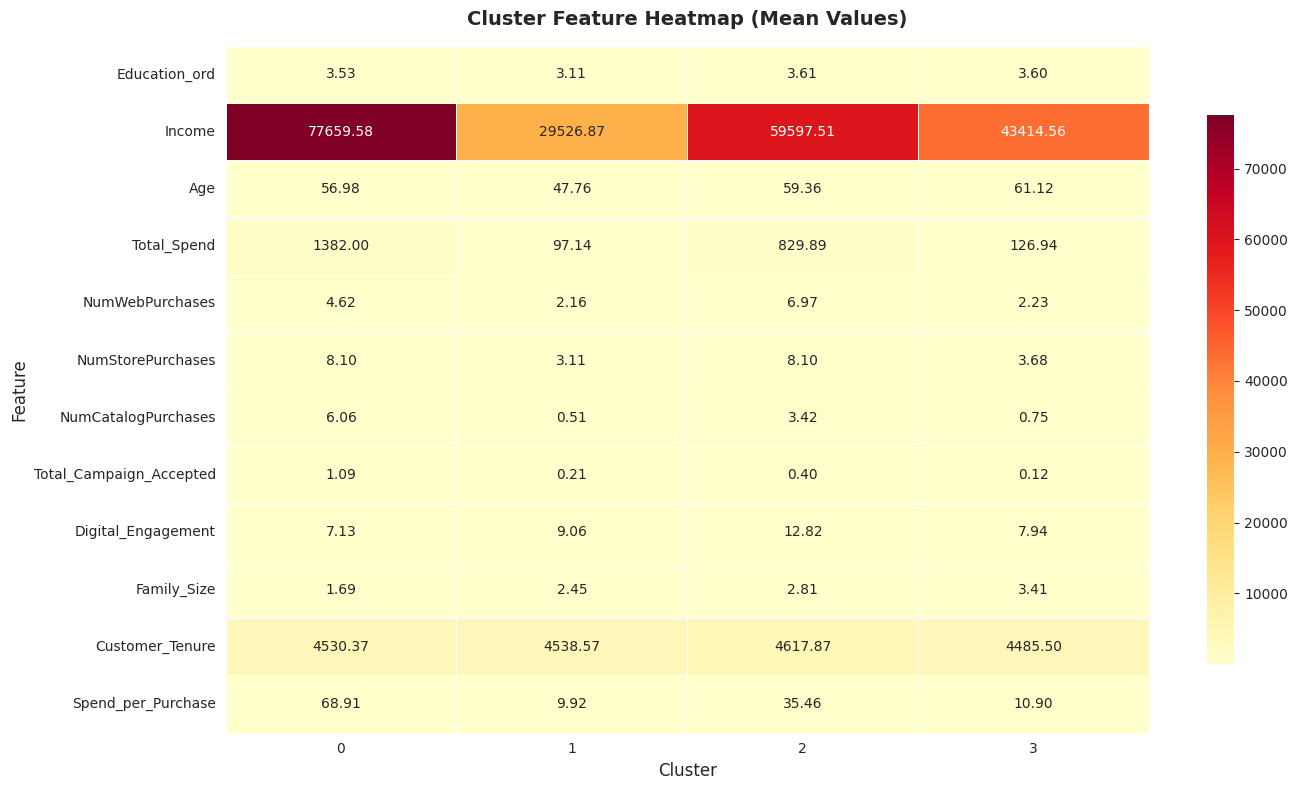

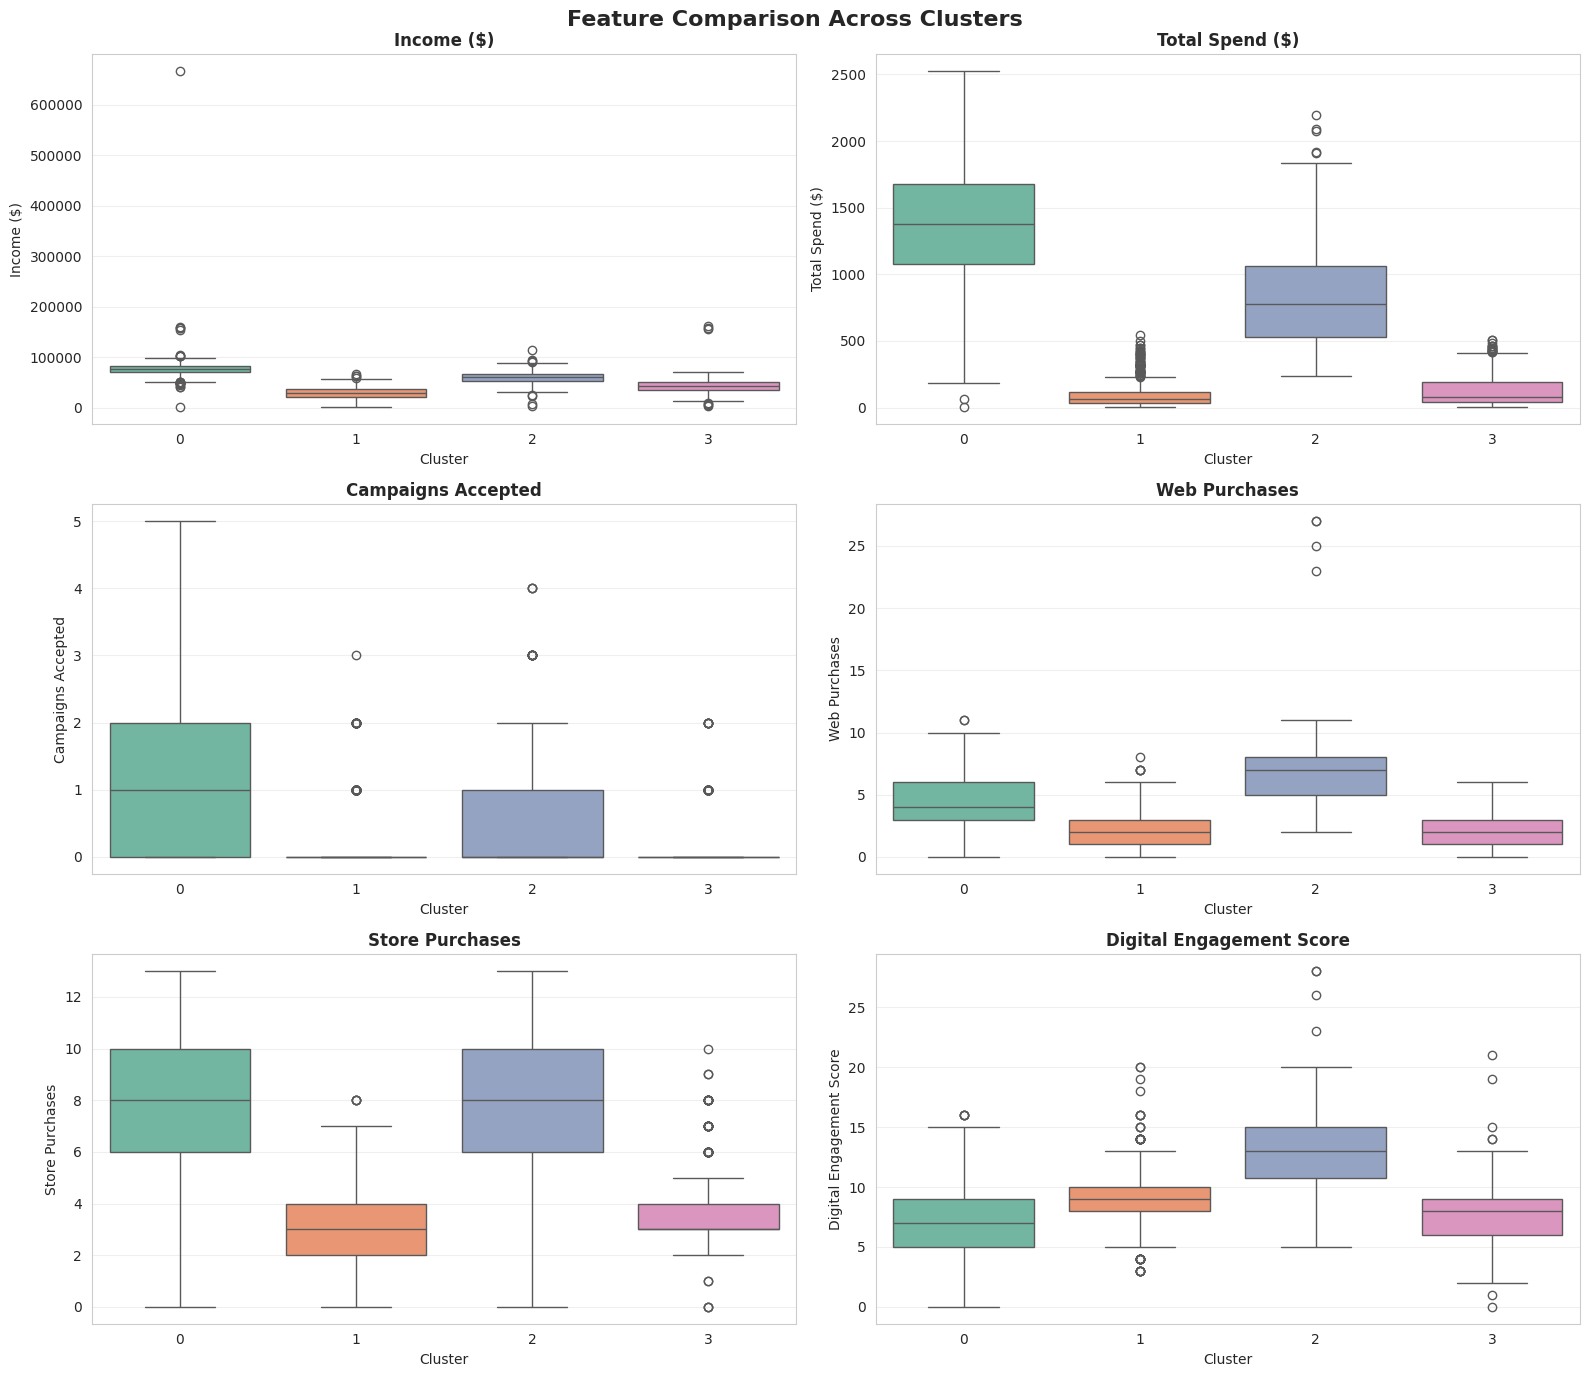

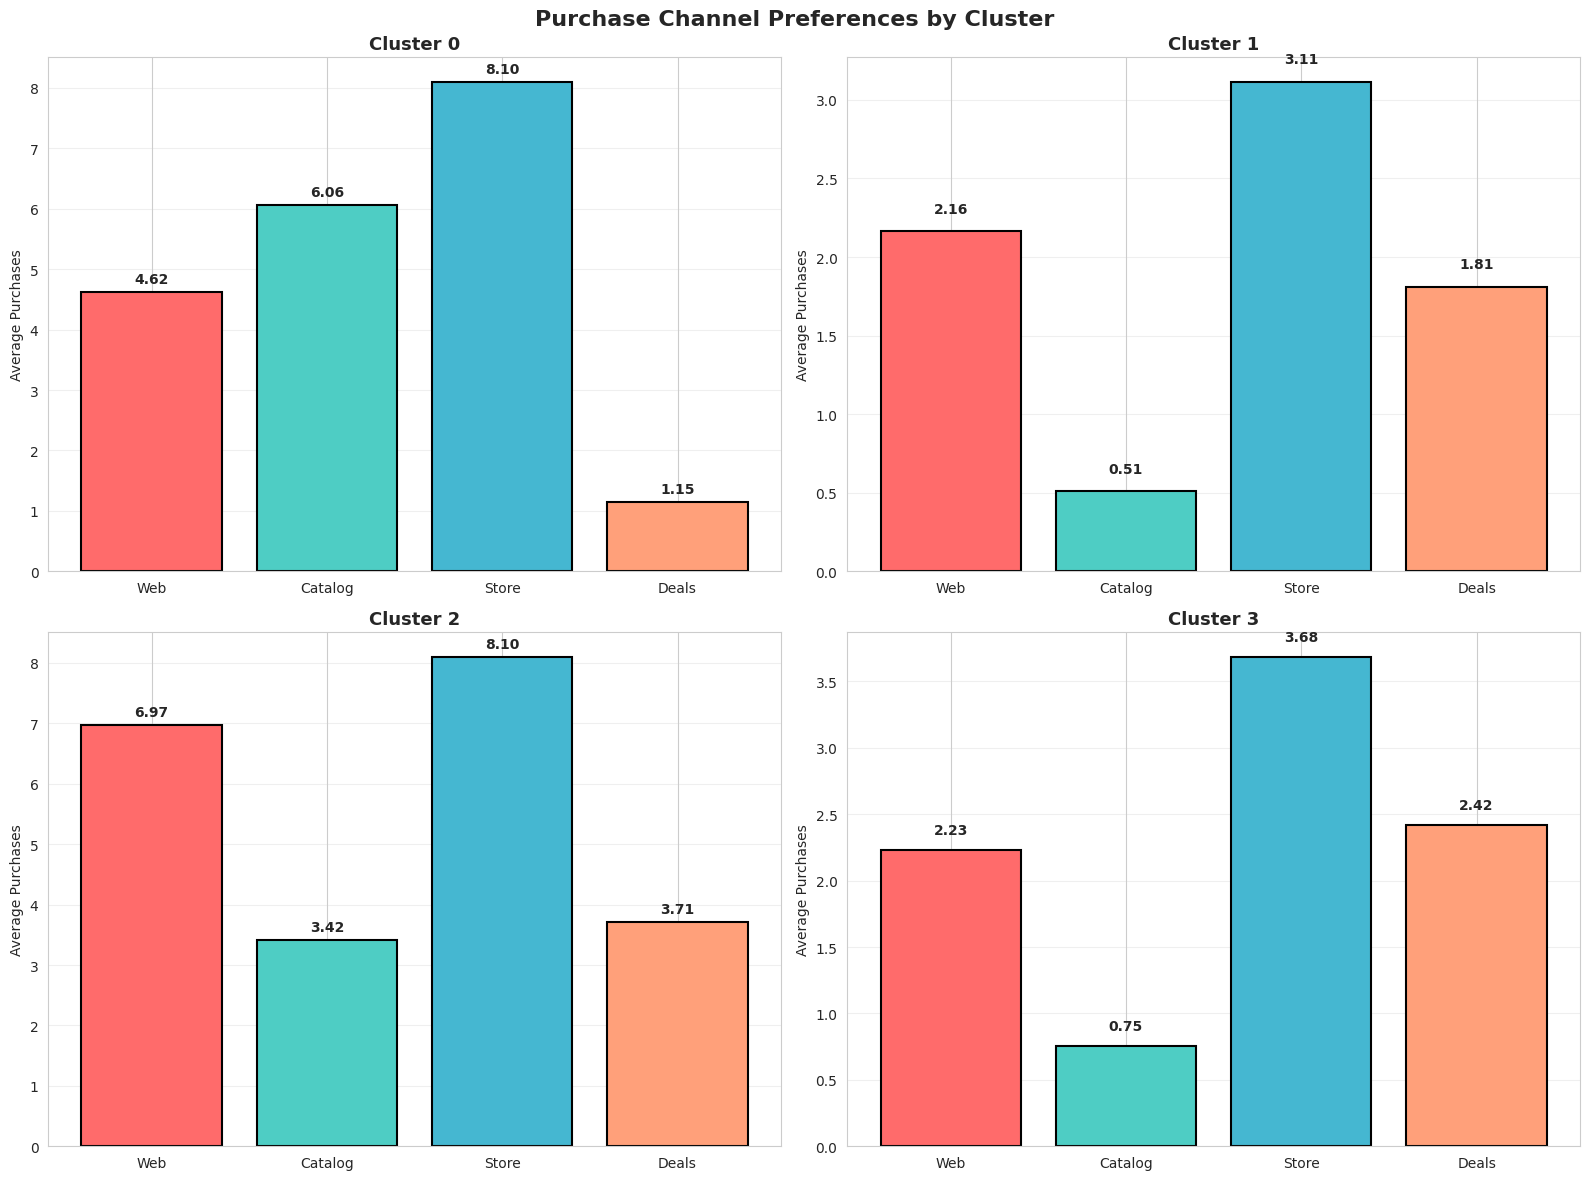

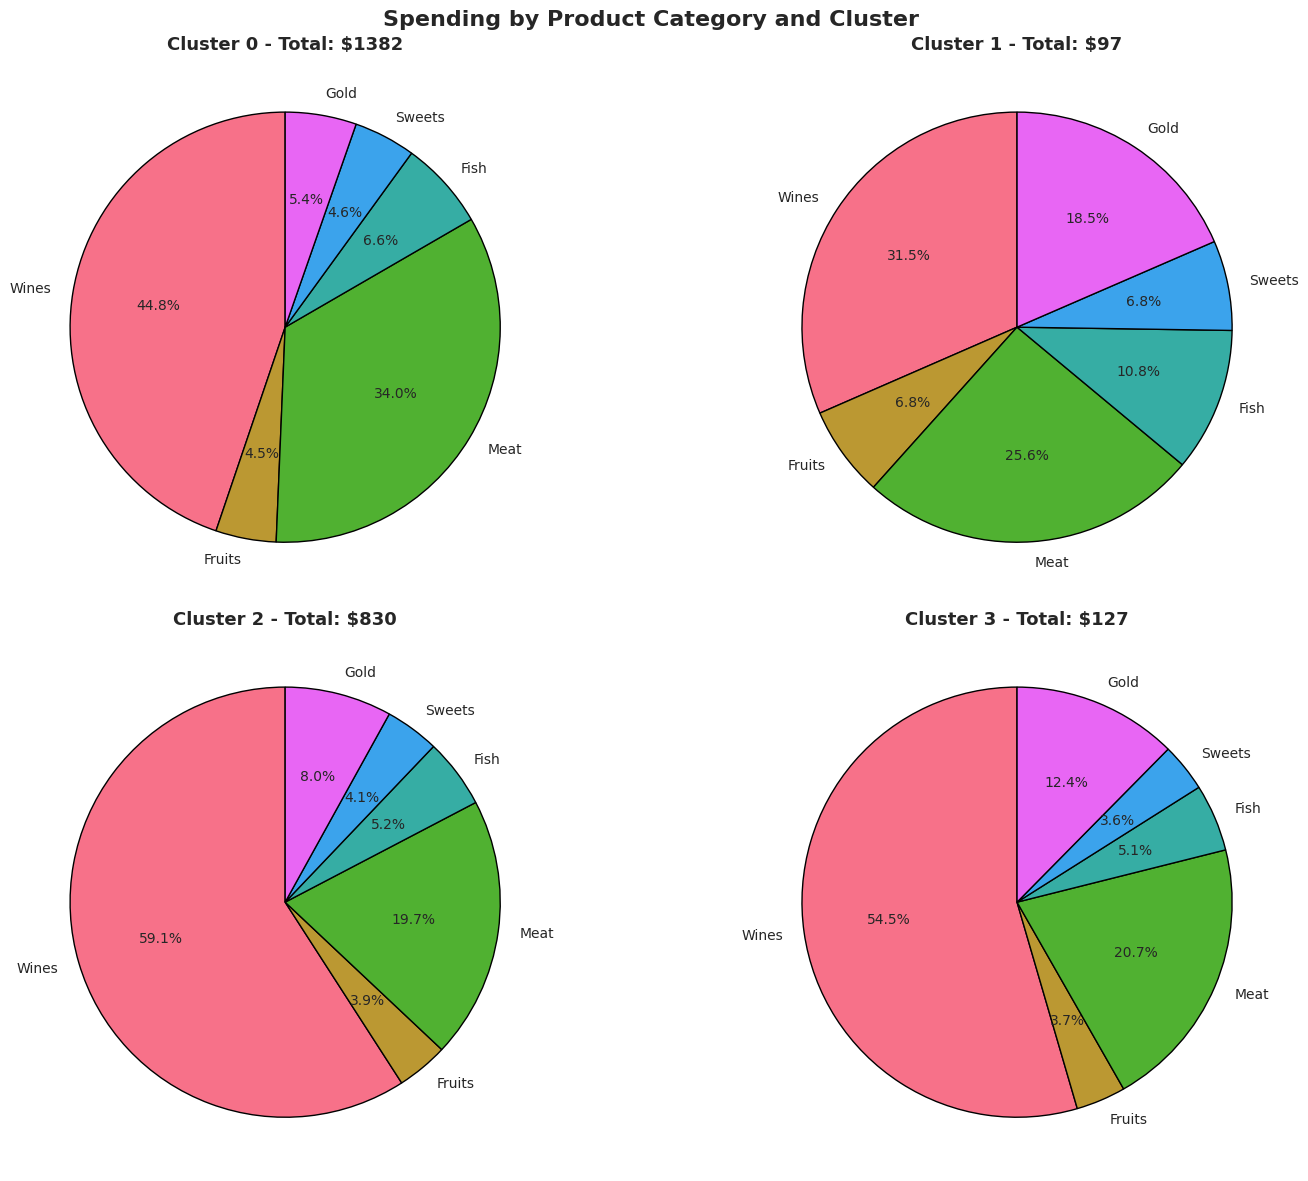


 Comprehensive Cluster Statistics:

 CLUSTER 0
   Size: 519 customers (23.2%)

   Demographics:
   - Average Age: 57.0 years
   - Average Income: $77,660
   - Education Level: 3.53
   - Family Size: 1.69

   Purchasing Behavior:
   - Total Spend: $1,382.00
   - Total Purchases: 19.93
   - Spend per Purchase: $68.91
   - Customer Tenure: 4530 days

   Channel Preferences:
   - Web Purchases: 4.62
   - Store Purchases: 8.10
   - Catalog Purchases: 6.06

   Marketing Engagement:
   - Campaigns Accepted: 1.09
   - Response Rate: 18.1%
   - Digital Engagement: 7.13
--------------------------------------------------------------------------------

 CLUSTER 1
   Size: 583 customers (26.0%)

   Demographics:
   - Average Age: 47.8 years
   - Average Income: $29,527
   - Education Level: 3.11
   - Family Size: 2.45

   Purchasing Behavior:
   - Total Spend: $97.14
   - Total Purchases: 7.60
   - Spend per Purchase: $9.92
   - Customer Tenure: 4539 days

   Channel Preferences:
   - Web Purchase

In [ ]:

print("="*80)
print("CLUSTER VISUALIZATION & ANALYSIS")
print("="*80)

# 5.1 Dimensionality Reduction for Visualization

# PCA Visualization
print("\n Performing PCA for 2D visualization...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(14, 6))

# PCA Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=df['Cluster'], cmap='viridis',
                      s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=11)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=11)
plt.title('Cluster Visualization (PCA)', fontweight='bold', fontsize=13)
plt.grid(alpha=0.3)

# Cluster Centers in PCA space
centers_pca = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c='red', s=300, alpha=0.8, edgecolors='black',
            linewidth=2, marker='X', label='Centroids')
plt.legend()

# t-SNE Visualization
print(" Performing t-SNE for 2D visualization (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                      c=df['Cluster'], cmap='viridis',
                      s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('t-SNE Dimension 1', fontsize=11)
plt.ylabel('t-SNE Dimension 2', fontsize=11)
plt.title('Cluster Visualization (t-SNE)', fontweight='bold', fontsize=13)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 5.2 Cluster Profiles - Comprehensive Table
print("\n📋 Detailed Cluster Profiles:")

profile_features = [
    'Education_ord', 'Income', 'Age', 'Total_Spend',
    'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases',
    'Total_Campaign_Accepted', 'Digital_Engagement',
    'Family_Size', 'Customer_Tenure', 'Spend_per_Purchase'
]

cluster_profiles = df.groupby('Cluster')[profile_features].mean()
print(cluster_profiles.round(2))

# Save cluster profiles
cluster_profiles.to_csv('cluster_profiles.csv')
print("\n Cluster profiles saved to 'cluster_profiles.csv'")

# 5.3 Cluster Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f',
            cmap='YlOrRd', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Cluster Feature Heatmap (Mean Values)',
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 5.4 Feature Comparison Across Clusters
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Feature Comparison Across Clusters', fontsize=16, fontweight='bold')

comparison_features = [
    ('Income', 'Income ($)'),
    ('Total_Spend', 'Total Spend ($)'),
    ('Total_Campaign_Accepted', 'Campaigns Accepted'),
    ('NumWebPurchases', 'Web Purchases'),
    ('NumStorePurchases', 'Store Purchases'),
    ('Digital_Engagement', 'Digital Engagement Score')
]

for idx, (feature, label) in enumerate(comparison_features):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    sns.boxplot(x='Cluster', y=feature, data=df, ax=ax, palette='Set2')
    ax.set_title(label, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(label)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5.5 Channel Preference by Cluster
channel_cols = ['NumWebPurchases', 'NumCatalogPurchases',
                'NumStorePurchases', 'NumDealsPurchases']
channel_by_cluster = df.groupby('Cluster')[channel_cols].mean()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Purchase Channel Preferences by Cluster', fontsize=16, fontweight='bold')

for idx in range(optimal_k):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    cluster_data = channel_by_cluster.loc[idx]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    ax.bar(range(len(cluster_data)), cluster_data, color=colors,
           edgecolor='black', linewidth=1.5)
    ax.set_xticks(range(len(cluster_data)))
    ax.set_xticklabels(['Web', 'Catalog', 'Store', 'Deals'], rotation=0)
    ax.set_title(f'Cluster {idx}', fontweight='bold', fontsize=13)
    ax.set_ylabel('Average Purchases')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, v in enumerate(cluster_data):
        ax.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 5.6 Spending Category Breakdown
spend_categories = ['MntWines', 'MntFruits', 'MntMeatProducts',
                    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
spend_by_cluster = df.groupby('Cluster')[spend_categories].mean()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Spending by Product Category and Cluster', fontsize=16, fontweight='bold')

for idx in range(optimal_k):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    cluster_spend = spend_by_cluster.loc[idx]
    category_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']

    colors = sns.color_palette('husl', len(category_names))
    ax.pie(cluster_spend, labels=category_names, autopct='%1.1f%%',
           startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
    ax.set_title(f'Cluster {idx} - Total: ${cluster_spend.sum():.0f}',
                 fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

# 5.7 Cluster Summary Statistics
print("\n Comprehensive Cluster Statistics:")
print("="*80)

for cluster_id in sorted(df['Cluster'].unique()):
    cluster_data = df[df['Cluster'] == cluster_id]

    print(f"\n CLUSTER {cluster_id}")
    print(f"   Size: {len(cluster_data):,} customers ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"\n   Demographics:")
    print(f"   - Average Age: {cluster_data['Age'].mean():.1f} years")
    print(f"   - Average Income: ${cluster_data['Income'].mean():,.0f}")
    print(f"   - Education Level: {cluster_data['Education_ord'].mean():.2f}")
    print(f"   - Family Size: {cluster_data['Family_Size'].mean():.2f}")

    print(f"\n   Purchasing Behavior:")
    print(f"   - Total Spend: ${cluster_data['Total_Spend'].mean():,.2f}")
    print(f"   - Total Purchases: {cluster_data['Total_Purchases'].mean():.2f}")
    print(f"   - Spend per Purchase: ${cluster_data['Spend_per_Purchase'].mean():.2f}")
    print(f"   - Customer Tenure: {cluster_data['Customer_Tenure'].mean():.0f} days")

    print(f"\n   Channel Preferences:")
    print(f"   - Web Purchases: {cluster_data['NumWebPurchases'].mean():.2f}")
    print(f"   - Store Purchases: {cluster_data['NumStorePurchases'].mean():.2f}")
    print(f"   - Catalog Purchases: {cluster_data['NumCatalogPurchases'].mean():.2f}")

    print(f"\n   Marketing Engagement:")
    print(f"   - Campaigns Accepted: {cluster_data['Total_Campaign_Accepted'].mean():.2f}")
    print(f"   - Response Rate: {cluster_data['Campaign_Response_Rate'].mean()*100:.1f}%")
    print(f"   - Digital Engagement: {cluster_data['Digital_Engagement'].mean():.2f}")

    print("-"*80)

print("\n" + "="*80)

##SECTION 6: STATISTICAL VALIDATION OF EDUCATION'S IMPACT


STATISTICAL VALIDATION

 Test 1: Education Level vs Total Spending
------------------------------------------------------------
Kruskal-Wallis H-test:
  H-statistic: 71.0185
  P-value: 0.000000
  Result: SIGNIFICANT (α = 0.05)

 Education level significantly impacts customer spending

 Post-hoc Pairwise Comparisons (Mann-Whitney U tests):
Comparison                U-statistic     P-value      Significant
----------------------------------------------------------------------
Education 1 vs 2      2685.00         0.000000     Yes
Education 1 vs 3      12091.50        0.000000     Yes
Education 1 vs 4      3610.00         0.000000     Yes
Education 1 vs 5      4667.00         0.000000     Yes
Education 2 vs 3      100800.00       0.006979     Yes
Education 2 vs 4      33111.50        0.019076     Yes
Education 2 vs 5      41108.50        0.000558     Yes
Education 3 vs 4      209171.00       0.925406     No
Education 3 vs 5      259797.50       0.101324     No
Education 4 vs 5      84623.

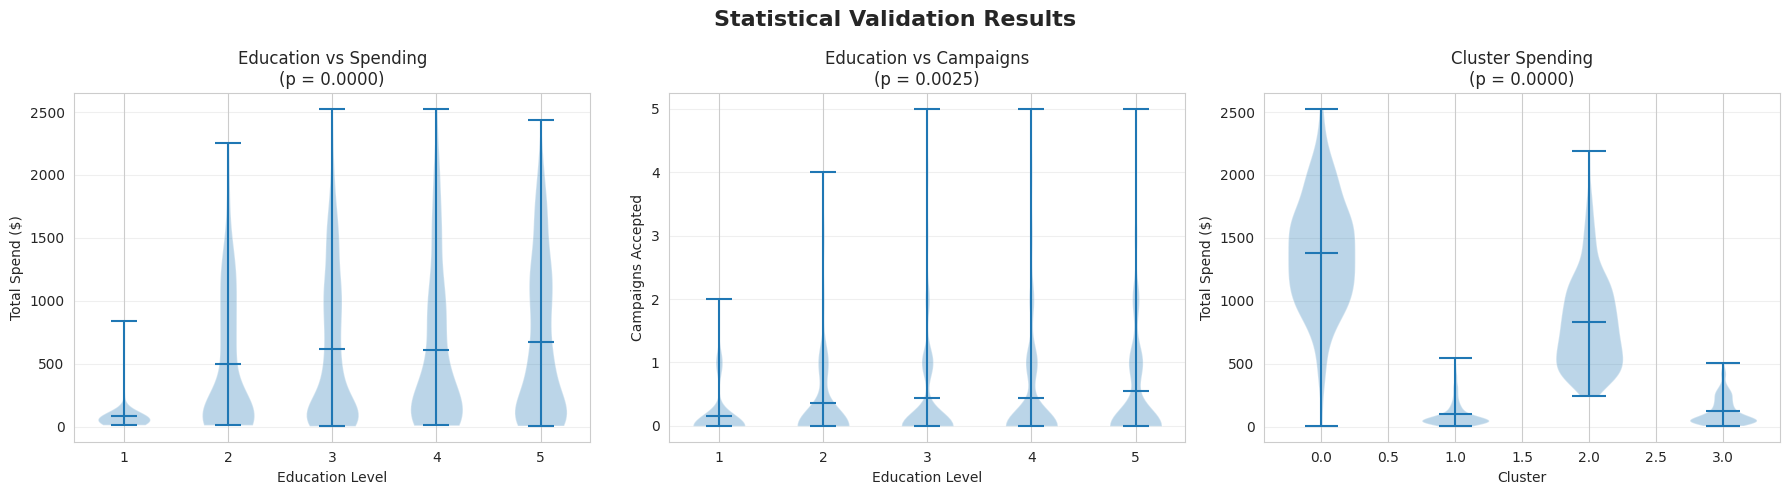

In [ ]:

from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations

print("="*80)
print("STATISTICAL VALIDATION")
print("="*80)

# 6.1 Education vs Spending
print("\n Test 1: Education Level vs Total Spending")
print("-"*60)

edu_levels = sorted(df['Education_ord'].unique())
spend_groups = [
    df[df['Education_ord'] == level]['Total_Spend'].dropna()
    for level in edu_levels
]

# Kruskal-Wallis test
h_stat, p_value = kruskal(*spend_groups)
print(f"Kruskal-Wallis H-test:")
print(f"  H-statistic: {h_stat:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Result: {'SIGNIFICANT' if p_value < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

if p_value < 0.05:
    print(f"\n Education level significantly impacts customer spending")

    # Post-hoc pairwise comparisons
    print(f"\n Post-hoc Pairwise Comparisons (Mann-Whitney U tests):")
    print(f"{'Comparison':<25} {'U-statistic':<15} {'P-value':<12} {'Significant'}")
    print("-"*70)

    for (level1, level2) in combinations(edu_levels, 2):
        group1 = df[df['Education_ord'] == level1]['Total_Spend'].dropna()
        group2 = df[df['Education_ord'] == level2]['Total_Spend'].dropna()

        u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
        sig = "Yes" if p_val < 0.05 else "No"

        print(f"Education {level1} vs {level2:<6} {u_stat:<15.2f} {p_val:<12.6f} {sig}")

# 6.2 Education vs Campaign Response
print("\n\n Test 2: Education Level vs Campaign Response")
print("-"*60)

response_groups = [
    df[df['Education_ord'] == level]['Total_Campaign_Accepted'].dropna()
    for level in edu_levels
]

h_stat2, p_value2 = kruskal(*response_groups)
print(f"Kruskal-Wallis H-test:")
print(f"  H-statistic: {h_stat2:.4f}")
print(f"  P-value: {p_value2:.6f}")
print(f"  Result: {'SIGNIFICANT' if p_value2 < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

if p_value2 < 0.05:
    print(f"\n Education level significantly impacts campaign responsiveness")

# 6.3 Cluster Differences
print("\n\n Test 3: Differences Across Clusters")
print("-"*60)

cluster_groups_spend = [
    df[df['Cluster'] == cluster]['Total_Spend'].dropna()
    for cluster in sorted(df['Cluster'].unique())
]

h_stat3, p_value3 = kruskal(*cluster_groups_spend)
print(f"Kruskal-Wallis H-test (Spending across clusters):")
print(f"  H-statistic: {h_stat3:.4f}")
print(f"  P-value: {p_value3:.6f}")
print(f"  Result: {'SIGNIFICANT' if p_value3 < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

if p_value3 < 0.05:
    print(f"\n Clusters show significantly different spending patterns")

# 6.4 Effect Sizes
print("\n\n Effect Size Analysis")
print("-"*60)

from scipy.stats import spearmanr

# Spearman correlation (ordinal data)
corr_spend, p_spend = spearmanr(df['Education_ord'], df['Total_Spend'])
corr_income, p_income = spearmanr(df['Education_ord'], df['Income'])
corr_campaign, p_campaign = spearmanr(df['Education_ord'], df['Total_Campaign_Accepted'])

print(f"Spearman Correlations with Education Level:")
print(f"  Education ↔ Spending:  ρ = {corr_spend:.4f}, p = {p_spend:.6f}")
print(f"  Education ↔ Income:    ρ = {corr_income:.4f}, p = {p_income:.6f}")
print(f"  Education ↔ Campaigns: ρ = {corr_campaign:.4f}, p = {p_campaign:.6f}")

# 6.5 Visualization of Statistical Tests
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Statistical Validation Results', fontsize=16, fontweight='bold')

# Education vs Spending
axes[0].violinplot([df[df['Education_ord'] == level]['Total_Spend'].dropna()
                     for level in edu_levels],
                    positions=edu_levels, showmeans=True)
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Total Spend ($)')
axes[0].set_title(f'Education vs Spending\n(p = {p_value:.4f})')
axes[0].grid(axis='y', alpha=0.3)

# Education vs Campaign Response
axes[1].violinplot([df[df['Education_ord'] == level]['Total_Campaign_Accepted'].dropna()
                     for level in edu_levels],
                    positions=edu_levels, showmeans=True)
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel('Campaigns Accepted')
axes[1].set_title(f'Education vs Campaigns\n(p = {p_value2:.4f})')
axes[1].grid(axis='y', alpha=0.3)

# Cluster Spending Distribution
axes[2].violinplot([df[df['Cluster'] == c]['Total_Spend'].dropna()
                     for c in sorted(df['Cluster'].unique())],
                    positions=sorted(df['Cluster'].unique()), showmeans=True)
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Total Spend ($)')
axes[2].set_title(f'Cluster Spending\n(p = {p_value3:.4f})')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)

##SECTION 7: MARKETING STRATEGY IMPLEMENTATION


PERSONALIZED MARKETING STRATEGY IMPLEMENTATION

 MARKETING STRATEGY SUMMARY

 CLUSTER 0: Budget-Conscious Educated
   Description: Educated but income-constrained customers

   Recommended Strategy:
   • Channels: Email, Newsletter
   • Offer Type: Discount & Value Bundles
   • Messaging: Value-for-money, practical benefits
   • Frequency: Monthly
   • Budget Allocation: 15%
   • Expected Response: 8%
   • Discount Range: 15-20%
--------------------------------------------------------------------------------

 CLUSTER 1: Digital Mid-Value
   Description: Digitally active omnichannel shoppers

   Recommended Strategy:
   • Channels: App Notifications, Email, Retargeting Ads
   • Offer Type: Cross-sell & Product Bundles
   • Messaging: Convenience, variety, seamless experience
   • Frequency: Bi-weekly
   • Budget Allocation: 35%
   • Expected Response: 18%
   • Discount Range: 10-15%
--------------------------------------------------------------------------------

 CLUSTER 2: Premium Hi

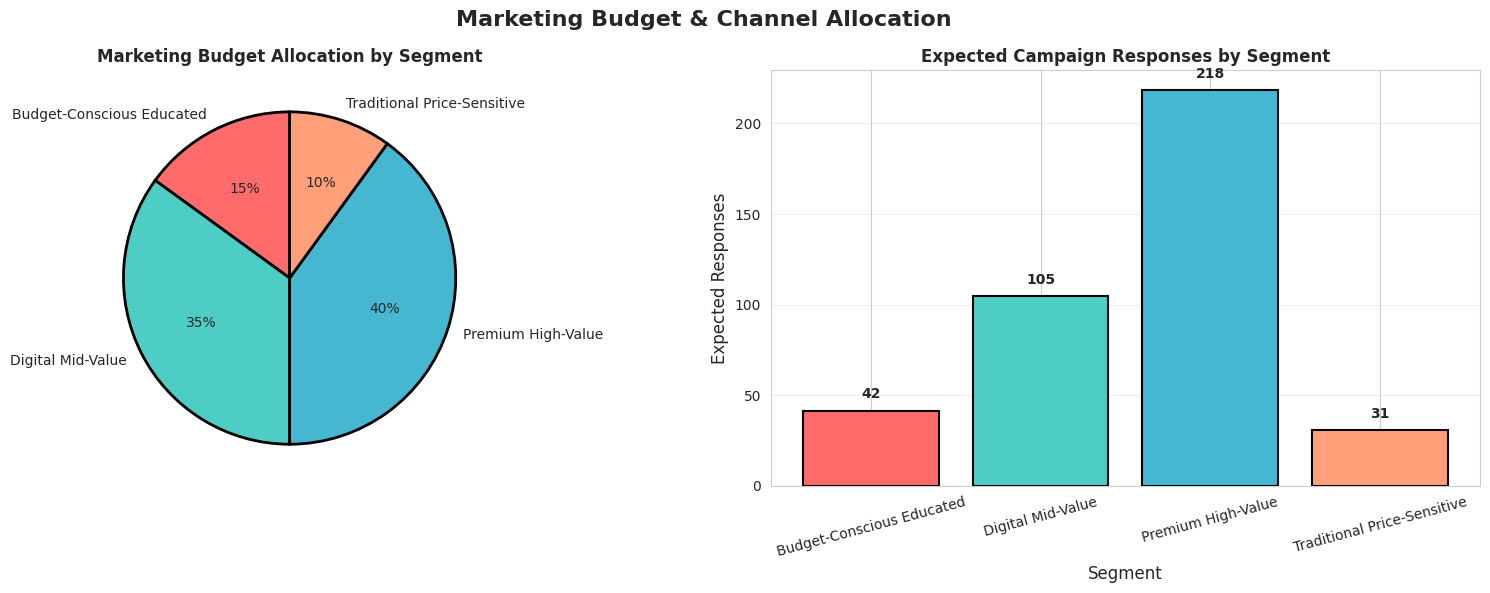


 EXPECTED ROI ANALYSIS

 Cluster 0: Budget-Conscious Educated
   Customers: 519
   Budget: $15,000 (15%)
   Contacts: 6,000
   Expected Responses: 480 (8%)
   Avg Order Value: $1,382.00
   Expected Revenue: $663,358
   Expected Profit: $199,007
   ROI: 1,226.7%
--------------------------------------------------------------------------------

 Cluster 1: Digital Mid-Value
   Customers: 583
   Budget: $35,000 (35%)
   Contacts: 14,000
   Expected Responses: 2,520 (18%)
   Avg Order Value: $97.14
   Expected Revenue: $244,786
   Expected Profit: $73,436
   ROI: 109.8%
--------------------------------------------------------------------------------

 Cluster 2: Premium High-Value
   Customers: 624
   Budget: $40,000 (40%)
   Contacts: 16,000
   Expected Responses: 5,600 (35%)
   Avg Order Value: $829.89
   Expected Revenue: $4,647,399
   Expected Profit: $1,394,220
   ROI: 3,385.5%
--------------------------------------------------------------------------------

 Cluster 3: Traditional Pr

In [ ]:

print("="*80)
print("PERSONALIZED MARKETING STRATEGY IMPLEMENTATION")
print("="*80)

# 7.1 Marketing Strategy Engine
class MarketingStrategyEngine:
    """
    Assigns personalized marketing strategies to customer segments
    """

    def __init__(self):
        self.strategies = {
            0: {
                'segment_name': 'Budget-Conscious Educated',
                'description': 'Educated but income-constrained customers',
                'channels': ['Email', 'Newsletter'],
                'offer_type': 'Discount & Value Bundles',
                'messaging': 'Value-for-money, practical benefits',
                'frequency': 'Monthly',
                'budget_allocation': 0.15,
                'expected_response_rate': 0.08,
                'recommended_discount': '15-20%'
            },
            1: {
                'segment_name': 'Digital Mid-Value',
                'description': 'Digitally active omnichannel shoppers',
                'channels': ['App Notifications', 'Email', 'Retargeting Ads'],
                'offer_type': 'Cross-sell & Product Bundles',
                'messaging': 'Convenience, variety, seamless experience',
                'frequency': 'Bi-weekly',
                'budget_allocation': 0.35,
                'expected_response_rate': 0.18,
                'recommended_discount': '10-15%'
            },
            2: {
                'segment_name': 'Premium High-Value',
                'description': 'Highest value, highly responsive customers',
                'channels': ['Personalized Email', 'Premium Catalog', 'VIP Events'],
                'offer_type': 'Exclusive Products & Loyalty Rewards',
                'messaging': 'Quality, exclusivity, sophistication',
                'frequency': 'Monthly (premium)',
                'budget_allocation': 0.40,
                'expected_response_rate': 0.35,
                'recommended_discount': '5-10% (or exclusive access)'
            },
            3: {
                'segment_name': 'Traditional Price-Sensitive',
                'description': 'Low income, store-centric, price-focused',
                'channels': ['SMS', 'In-store Signage', 'Local Ads'],
                'offer_type': 'Clear Price Discounts',
                'messaging': 'Immediate savings, affordability',
                'frequency': 'Event-based (seasonal)',
                'budget_allocation': 0.10,
                'expected_response_rate': 0.06,
                'recommended_discount': '20-25%'
            }
        }

    def get_strategy(self, cluster_id):
        """Get strategy for a specific cluster"""
        return self.strategies.get(cluster_id, None)

    def assign_strategies(self, dataframe):
        """Apply strategies to entire dataframe"""
        df_copy = dataframe.copy()

        df_copy['Segment_Name'] = df_copy['Cluster'].map(
            lambda x: self.strategies[x]['segment_name']
        )
        df_copy['Primary_Channel'] = df_copy['Cluster'].map(
            lambda x: ', '.join(self.strategies[x]['channels'][:2])
        )
        df_copy['Offer_Type'] = df_copy['Cluster'].map(
            lambda x: self.strategies[x]['offer_type']
        )
        df_copy['Contact_Frequency'] = df_copy['Cluster'].map(
            lambda x: self.strategies[x]['frequency']
        )

        return df_copy

    def print_strategy_summary(self):
        """Print comprehensive strategy summary"""
        print("\n MARKETING STRATEGY SUMMARY")
        print("="*80)

        for cluster_id, strategy in self.strategies.items():
            print(f"\n CLUSTER {cluster_id}: {strategy['segment_name']}")
            print(f"   Description: {strategy['description']}")
            print(f"\n   Recommended Strategy:")
            print(f"   • Channels: {', '.join(strategy['channels'])}")
            print(f"   • Offer Type: {strategy['offer_type']}")
            print(f"   • Messaging: {strategy['messaging']}")
            print(f"   • Frequency: {strategy['frequency']}")
            print(f"   • Budget Allocation: {strategy['budget_allocation']*100:.0f}%")
            print(f"   • Expected Response: {strategy['expected_response_rate']*100:.0f}%")
            print(f"   • Discount Range: {strategy['recommended_discount']}")
            print("-"*80)

# 7.2 Initialize Strategy Engine
strategy_engine = MarketingStrategyEngine()

# Print strategy summary
strategy_engine.print_strategy_summary()

# 7.3 Apply Strategies to DataFrame
df_with_strategy = strategy_engine.assign_strategies(df)

print("\n Marketing strategies assigned to all customers")
print(f"\nSample of customer assignments:")
print(df_with_strategy[['Cluster', 'Segment_Name', 'Primary_Channel',
                         'Offer_Type', 'Total_Spend']].head(10))

# Save customer segments with strategies
df_with_strategy.to_csv('customer_segments_with_strategies.csv', index=False)
print("\n Customer segments saved to 'customer_segments_with_strategies.csv'")

# 7.4 Strategy Allocation Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Marketing Budget & Channel Allocation', fontsize=16, fontweight='bold')

# Budget allocation
budget_data = [strategy_engine.strategies[i]['budget_allocation']
               for i in range(optimal_k)]
segment_names = [strategy_engine.strategies[i]['segment_name']
                 for i in range(optimal_k)]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
axes[0].pie(budget_data, labels=segment_names, autopct='%1.0f%%',
            startangle=90, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 2})
axes[0].set_title('Marketing Budget Allocation by Segment', fontweight='bold')

# Expected ROI comparison
cluster_sizes = df['Cluster'].value_counts().sort_index()
expected_responses = [cluster_sizes[i] * strategy_engine.strategies[i]['expected_response_rate']
                      for i in range(optimal_k)]

axes[1].bar(segment_names, expected_responses, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('Segment', fontsize=12)
axes[1].set_ylabel('Expected Responses', fontsize=12)
axes[1].set_title('Expected Campaign Responses by Segment', fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(expected_responses):
    axes[1].text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 7.5 Calculate Expected ROI
print("\n EXPECTED ROI ANALYSIS")
print("="*80)

# Assumptions
total_marketing_budget = 100000  # $100,000
avg_order_margin = 0.30  # 30% profit margin
campaign_cost_per_contact = 2.50  # $2.50 per customer contact

for cluster_id in range(optimal_k):
    strategy = strategy_engine.strategies[cluster_id]
    cluster_size = cluster_sizes[cluster_id]

    # Calculate expected outcomes
    budget_allocated = total_marketing_budget * strategy['budget_allocation']
    contacts_affordable = budget_allocated / campaign_cost_per_contact
    expected_responses = contacts_affordable * strategy['expected_response_rate']
    avg_order_value = df[df['Cluster'] == cluster_id]['Total_Spend'].mean()
    expected_revenue = expected_responses * avg_order_value
    expected_profit = expected_revenue * avg_order_margin
    roi = ((expected_profit - budget_allocated) / budget_allocated) * 100

    print(f"\n Cluster {cluster_id}: {strategy['segment_name']}")
    print(f"   Customers: {cluster_size:,}")
    print(f"   Budget: ${budget_allocated:,.0f} ({strategy['budget_allocation']*100:.0f}%)")
    print(f"   Contacts: {contacts_affordable:,.0f}")
    print(f"   Expected Responses: {expected_responses:,.0f} ({strategy['expected_response_rate']*100:.0f}%)")
    print(f"   Avg Order Value: ${avg_order_value:,.2f}")
    print(f"   Expected Revenue: ${expected_revenue:,.0f}")
    print(f"   Expected Profit: ${expected_profit:,.0f}")
    print(f"   ROI: {roi:,.1f}%")
    print("-"*80)

print("\n" + "="*80)

##SECTION 8: A/B TESTING FRAMEWORK & SIMULATION


A/B TESTING FRAMEWORK

 Initializing A/B Test Framework...

 A/B groups created:
   Control: 1,121 customers
   Treatment: 1,119 customers

 Campaign responses simulated with 15% expected lift

COMPREHENSIVE A/B TEST RESULTS

 OVERALL RESULTS (All Clusters Combined)
--------------------------------------------------------------------------------

Response Rate Test:
  Control Rate: 17.93% (201/1121)
  Treatment Rate: 20.20% (226/1119)
  Lift: 12.64%
  Z-statistic: 1.3653
  P-value: 0.172162
  Result: ❌ NOT SIGNIFICANT (α = 0.05)

Average Order Value Test:
  Control AOV: $624.81
  Treatment AOV: $665.58
  Difference: $40.77
  Lift: 6.53%
  T-statistic: 0.8924
  P-value: 0.372681
  Result: ❌ NOT SIGNIFICANT (α = 0.05)


 CLUSTER 0 RESULTS
--------------------------------------------------------------------------------

Response Rate Test:
  Control Rate: 8.46%
  Treatment Rate: 7.72%
  Lift: -8.74%
  P-value: 0.757411
  Result: ❌ NOT SIGNIFICANT

Average Order Value Test:
  Control AOV: 

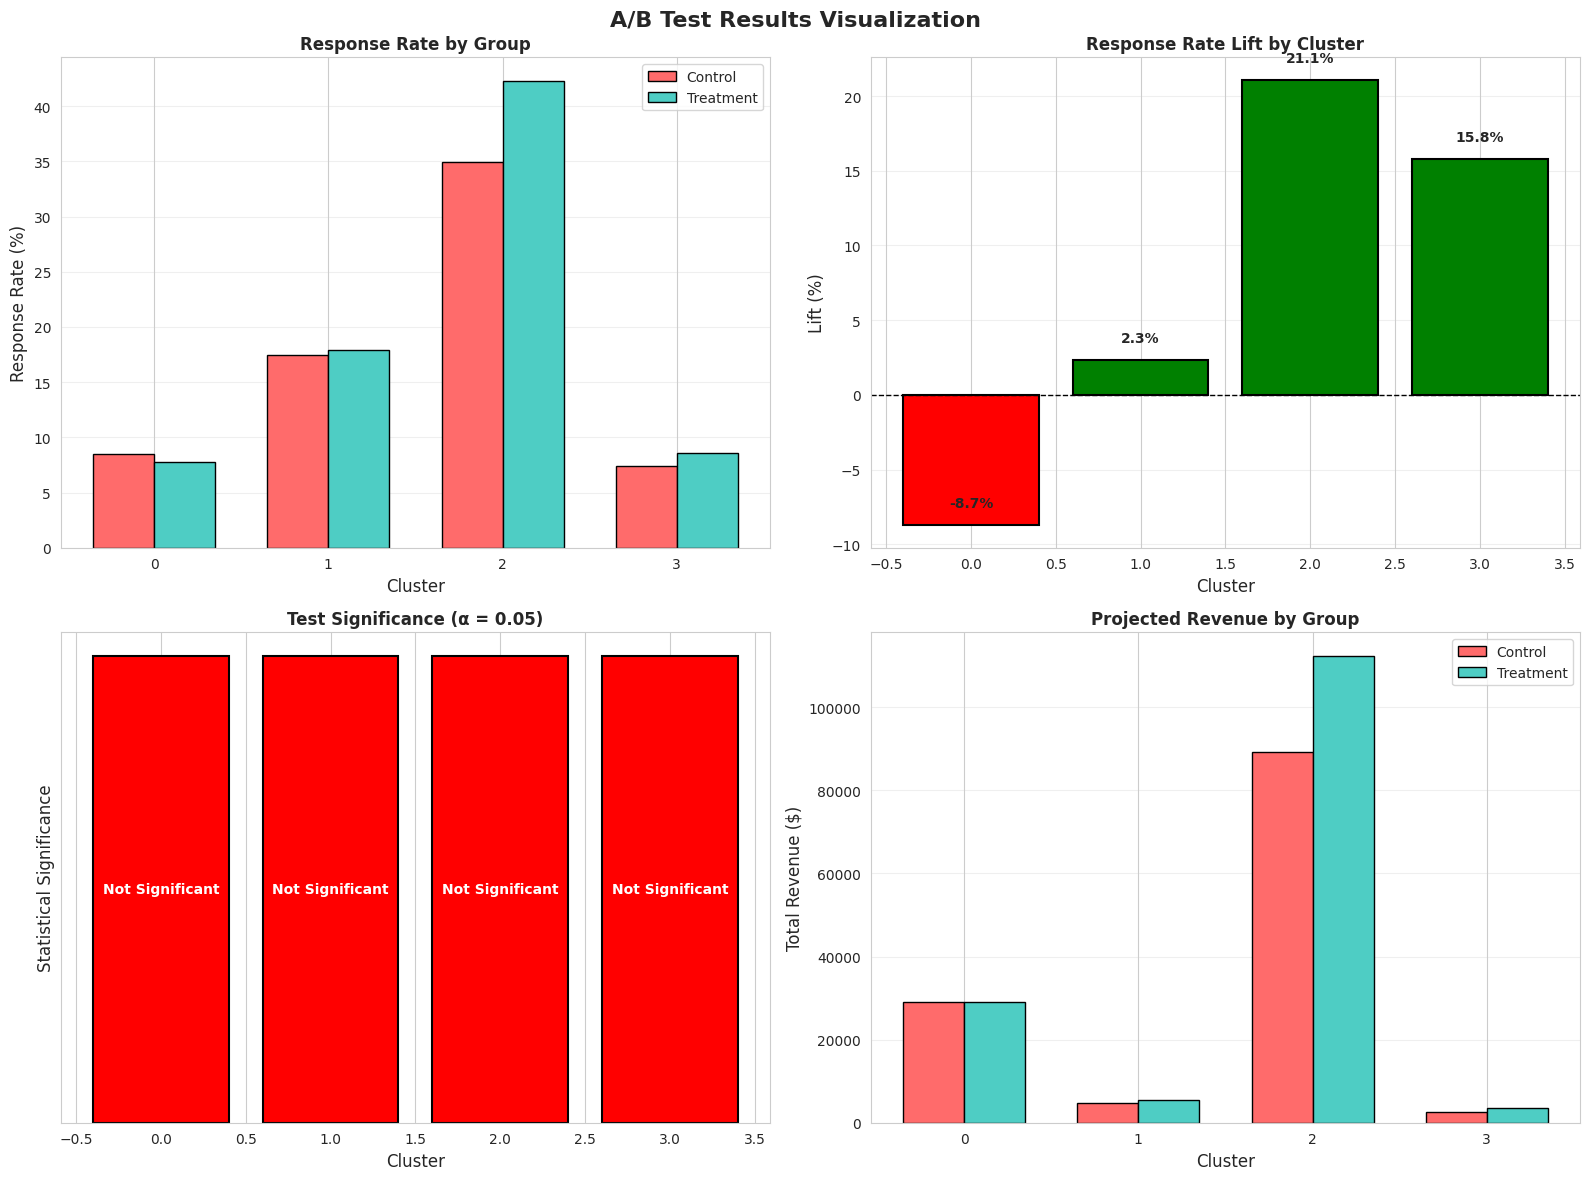


 A/B test data saved to 'ab_test_results.csv'


 BUSINESS IMPACT SUMMARY

Campaign Performance:
  Control Group:
    - Responses: 201
    - Revenue: $125,586.22

  Treatment Group (Personalized Strategy):
    - Responses: 226
    - Revenue: $150,420.44

  Impact:
    - Additional Responses: 25
    - Additional Revenue: $24,834.21
    - Revenue Lift: 19.77%

  Annualized Projection (12 campaigns/year):
    - Additional Annual Revenue: $596,021.13



In [ ]:

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import numpy as np


print("="*80)
print("A/B TESTING FRAMEWORK")
print("="*80)

# 8.1 A/B Test Framework Class
class ABTestFramework:
    """
    Complete A/B testing framework for evaluating marketing strategies
    """

    def __init__(self, dataframe, cluster_col='Cluster'):
        self.df = dataframe.copy()
        self.cluster_col = cluster_col
        self.results = {}

    def create_test_groups(self, test_ratio=0.5, random_state=42):
        """
        Split each cluster into control and treatment groups

        Parameters:
        - test_ratio: proportion assigned to treatment (default 50/50)
        - random_state: for reproducibility
        """
        np.random.seed(random_state)

        self.df['AB_Group'] = 'control'

        for cluster in self.df[self.cluster_col].unique():
            cluster_mask = self.df[self.cluster_col] == cluster
            cluster_indices = self.df[cluster_mask].index.tolist()

            # Randomly select treatment group
            n_treatment = int(len(cluster_indices) * test_ratio)
            treatment_indices = np.random.choice(cluster_indices,
                                                 size=n_treatment,
                                                 replace=False)

            self.df.loc[treatment_indices, 'AB_Group'] = 'treatment'

        print(f"\n A/B groups created:")
        print(f"   Control: {(self.df['AB_Group'] == 'control').sum():,} customers")
        print(f"   Treatment: {(self.df['AB_Group'] == 'treatment').sum():,} customers")

        return self.df

    def simulate_campaign_response(self, expected_lift=0.15):
        """
        Simulate campaign responses with expected lift for treatment group

        Parameters:
        - expected_lift: expected improvement in treatment group (e.g., 0.15 = 15% lift)
        """
        # Simulate based on cluster-specific response rates
        self.df['Simulated_Response'] = 0
        self.df['Simulated_AOV'] = 0.0

        for cluster in self.df[self.cluster_col].unique():
            strategy = MarketingStrategyEngine().strategies[cluster]
            base_rate = strategy['expected_response_rate']
            avg_spend = self.df[self.df[self.cluster_col] == cluster]['Total_Spend'].mean()

            # Control group: base rate
            control_mask = (self.df[self.cluster_col] == cluster) & (self.df['AB_Group'] == 'control')
            n_control = control_mask.sum()
            control_responses = np.random.binomial(1, base_rate, n_control)
            self.df.loc[control_mask, 'Simulated_Response'] = control_responses

            # Simulate spending for responders
            control_responders = control_responses.sum()
            if control_responders > 0:
                control_spending = np.random.normal(avg_spend, avg_spend * 0.3, n_control)
                control_spending = np.maximum(control_spending, 0)  # No negative spending
                self.df.loc[control_mask, 'Simulated_AOV'] = control_spending * control_responses

            # Treatment group: base rate + lift
            treatment_mask = (self.df[self.cluster_col] == cluster) & (self.df['AB_Group'] == 'treatment')
            n_treatment = treatment_mask.sum()
            treatment_rate = min(base_rate * (1 + expected_lift), 0.95)  # Cap at 95%
            treatment_responses = np.random.binomial(1, treatment_rate, n_treatment)
            self.df.loc[treatment_mask, 'Simulated_Response'] = treatment_responses

            # Treatment group gets slightly higher AOV due to personalization
            treatment_responders = treatment_responses.sum()
            if treatment_responders > 0:
                treatment_spending = np.random.normal(avg_spend * 1.05, avg_spend * 0.3, n_treatment)
                treatment_spending = np.maximum(treatment_spending, 0)
                self.df.loc[treatment_mask, 'Simulated_AOV'] = treatment_spending * treatment_responses

        print(f"\n Campaign responses simulated with {expected_lift*100:.0f}% expected lift")

        return self.df

    def test_response_rate(self, cluster_id=None):
        """
        Two-proportion z-test for response rate difference

        Parameters:
        - cluster_id: specific cluster to test (None = all clusters)
        """
        if cluster_id is not None:
            cluster_data = self.df[self.df[self.cluster_col] == cluster_id]
            cluster_label = f"Cluster {cluster_id}"
        else:
            cluster_data = self.df
            cluster_label = "All Clusters"

        control = cluster_data[cluster_data['AB_Group'] == 'control']
        treatment = cluster_data[cluster_data['AB_Group'] == 'treatment']

        control_responses = control['Simulated_Response'].sum()
        treatment_responses = treatment['Simulated_Response'].sum()

        control_rate = control_responses / len(control)
        treatment_rate = treatment_responses / len(treatment)

        # Two-proportion z-test
        counts = np.array([treatment_responses, control_responses])
        nobs = np.array([len(treatment), len(control)])

        stat, pval = proportions_ztest(counts, nobs)

        # Calculate lift
        if control_rate > 0:
            lift = ((treatment_rate - control_rate) / control_rate) * 100
        else:
            lift = 0

        result = {
            'cluster': cluster_label,
            'control_n': len(control),
            'treatment_n': len(treatment),
            'control_responses': control_responses,
            'treatment_responses': treatment_responses,
            'control_rate': control_rate,
            'treatment_rate': treatment_rate,
            'lift_pct': lift,
            'z_statistic': stat,
            'p_value': pval,
            'significant': pval < 0.05
        }

        return result

    def test_aov_difference(self, cluster_id=None):
        """
        T-test for average order value difference

        Parameters:
        - cluster_id: specific cluster to test (None = all clusters)
        """
        if cluster_id is not None:
            cluster_data = self.df[self.df[self.cluster_col] == cluster_id]
            cluster_label = f"Cluster {cluster_id}"
        else:
            cluster_data = self.df
            cluster_label = "All Clusters"

        # Filter only responders
        control = cluster_data[
            (cluster_data['AB_Group'] == 'control') &
            (cluster_data['Simulated_Response'] == 1)
        ]['Simulated_AOV']

        treatment = cluster_data[
            (cluster_data['AB_Group'] == 'treatment') &
            (cluster_data['Simulated_Response'] == 1)
        ]['Simulated_AOV']

        if len(control) > 1 and len(treatment) > 1:
            stat, pval = ttest_ind(treatment, control)

            control_mean = control.mean()
            treatment_mean = treatment.mean()

            if control_mean > 0:
                lift = ((treatment_mean - control_mean) / control_mean) * 100
            else:
                lift = 0

            result = {
                'cluster': cluster_label,
                'control_n': len(control),
                'treatment_n': len(treatment),
                'control_mean': control_mean,
                'treatment_mean': treatment_mean,
                'difference': treatment_mean - control_mean,
                'lift_pct': lift,
                't_statistic': stat,
                'p_value': pval,
                'significant': pval < 0.05
            }
        else:
            result = {
                'cluster': cluster_label,
                'error': 'Insufficient data for statistical test'
            }

        return result

    def generate_comprehensive_report(self):
        """
        Generate complete A/B test report for all clusters
        """
        print("\n" + "="*80)
        print("COMPREHENSIVE A/B TEST RESULTS")
        print("="*80)

        # Overall results
        print("\n OVERALL RESULTS (All Clusters Combined)")
        print("-"*80)

        overall_response = self.test_response_rate()
        print(f"\nResponse Rate Test:")
        print(f"  Control Rate: {overall_response['control_rate']*100:.2f}% ({overall_response['control_responses']}/{overall_response['control_n']})")
        print(f"  Treatment Rate: {overall_response['treatment_rate']*100:.2f}% ({overall_response['treatment_responses']}/{overall_response['treatment_n']})")
        print(f"  Lift: {overall_response['lift_pct']:.2f}%")
        print(f"  Z-statistic: {overall_response['z_statistic']:.4f}")
        print(f"  P-value: {overall_response['p_value']:.6f}")
        print(f"  Result: {' SIGNIFICANT' if overall_response['significant'] else '❌ NOT SIGNIFICANT'} (α = 0.05)")

        overall_aov = self.test_aov_difference()
        if 'error' not in overall_aov:
            print(f"\nAverage Order Value Test:")
            print(f"  Control AOV: ${overall_aov['control_mean']:.2f}")
            print(f"  Treatment AOV: ${overall_aov['treatment_mean']:.2f}")
            print(f"  Difference: ${overall_aov['difference']:.2f}")
            print(f"  Lift: {overall_aov['lift_pct']:.2f}%")
            print(f"  T-statistic: {overall_aov['t_statistic']:.4f}")
            print(f"  P-value: {overall_aov['p_value']:.6f}")
            print(f"  Result: {' SIGNIFICANT' if overall_aov['significant'] else '❌ NOT SIGNIFICANT'} (α = 0.05)")

        # Cluster-specific results
        response_results = []
        aov_results = []

        for cluster in sorted(self.df[self.cluster_col].unique()):
            print(f"\n\n CLUSTER {cluster} RESULTS")
            print("-"*80)

            cluster_response = self.test_response_rate(cluster)
            response_results.append(cluster_response)

            print(f"\nResponse Rate Test:")
            print(f"  Control Rate: {cluster_response['control_rate']*100:.2f}%")
            print(f"  Treatment Rate: {cluster_response['treatment_rate']*100:.2f}%")
            print(f"  Lift: {cluster_response['lift_pct']:.2f}%")
            print(f"  P-value: {cluster_response['p_value']:.6f}")
            print(f"  Result: {' SIGNIFICANT' if cluster_response['significant'] else '❌ NOT SIGNIFICANT'}")

            cluster_aov = self.test_aov_difference(cluster)
            aov_results.append(cluster_aov)

            if 'error' not in cluster_aov:
                print(f"\nAverage Order Value Test:")
                print(f"  Control AOV: ${cluster_aov['control_mean']:.2f}")
                print(f"  Treatment AOV: ${cluster_aov['treatment_mean']:.2f}")
                print(f"  Lift: {cluster_aov['lift_pct']:.2f}%")
                print(f"  P-value: {cluster_aov['p_value']:.6f}")
                print(f"  Result: {' SIGNIFICANT' if cluster_aov['significant'] else '❌ NOT SIGNIFICANT'}")

        self.results = {
            'overall_response': overall_response,
            'overall_aov': overall_aov,
            'cluster_response': response_results,
            'cluster_aov': aov_results
        }

        return self.results

    def visualize_results(self):
        """
        Create comprehensive visualization of A/B test results
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('A/B Test Results Visualization', fontsize=16, fontweight='bold')

        # 1. Response Rate Comparison
        clusters = sorted(self.df[self.cluster_col].unique())
        control_rates = []
        treatment_rates = []

        for cluster in clusters:
            result = self.test_response_rate(cluster)
            control_rates.append(result['control_rate'] * 100)
            treatment_rates.append(result['treatment_rate'] * 100)

        x = np.arange(len(clusters))
        width = 0.35

        axes[0, 0].bar(x - width/2, control_rates, width, label='Control',
                       color='#FF6B6B', edgecolor='black')
        axes[0, 0].bar(x + width/2, treatment_rates, width, label='Treatment',
                       color='#4ECDC4', edgecolor='black')
        axes[0, 0].set_xlabel('Cluster', fontsize=12)
        axes[0, 0].set_ylabel('Response Rate (%)', fontsize=12)
        axes[0, 0].set_title('Response Rate by Group', fontweight='bold')
        axes[0, 0].set_xticks(x)
        axes[0, 0].set_xticklabels(clusters)
        axes[0, 0].legend()
        axes[0, 0].grid(axis='y', alpha=0.3)

        # 2. Lift Percentage
        lifts = [self.test_response_rate(c)['lift_pct'] for c in clusters]
        colors = ['green' if l > 0 else 'red' for l in lifts]

        axes[0, 1].bar(clusters, lifts, color=colors, edgecolor='black', linewidth=1.5)
        axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[0, 1].set_xlabel('Cluster', fontsize=12)
        axes[0, 1].set_ylabel('Lift (%)', fontsize=12)
        axes[0, 1].set_title('Response Rate Lift by Cluster', fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)

        for i, v in enumerate(lifts):
            axes[0, 1].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

        # 3. Statistical Significance
        significance = [self.test_response_rate(c)['significant'] for c in clusters]
        sig_colors = ['green' if s else 'red' for s in significance]
        sig_labels = ['Significant' if s else 'Not Significant' for s in significance]

        axes[1, 0].bar(clusters, [1]*len(clusters), color=sig_colors,
                       edgecolor='black', linewidth=1.5)
        axes[1, 0].set_xlabel('Cluster', fontsize=12)
        axes[1, 0].set_ylabel('Statistical Significance', fontsize=12)
        axes[1, 0].set_title('Test Significance (α = 0.05)', fontweight='bold')
        axes[1, 0].set_yticks([])

        for i, (c, label) in enumerate(zip(clusters, sig_labels)):
            axes[1, 0].text(i, 0.5, label, ha='center', va='center',
                           fontweight='bold', color='white', fontsize=10)

        # 4. Revenue Impact
        revenue_control = []
        revenue_treatment = []

        for cluster in clusters:
            cluster_data = self.df[self.df[self.cluster_col] == cluster]

            control_rev = cluster_data[cluster_data['AB_Group'] == 'control']['Simulated_AOV'].sum()
            treatment_rev = cluster_data[cluster_data['AB_Group'] == 'treatment']['Simulated_AOV'].sum()

            revenue_control.append(control_rev)
            revenue_treatment.append(treatment_rev)

        axes[1, 1].bar(x - width/2, revenue_control, width, label='Control',
                       color='#FF6B6B', edgecolor='black')
        axes[1, 1].bar(x + width/2, revenue_treatment, width, label='Treatment',
                       color='#4ECDC4', edgecolor='black')
        axes[1, 1].set_xlabel('Cluster', fontsize=12)
        axes[1, 1].set_ylabel('Total Revenue ($)', fontsize=12)
        axes[1, 1].set_title('Projected Revenue by Group', fontweight='bold')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(clusters)
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

# 8.2 Initialize and Run A/B Test
print("\n Initializing A/B Test Framework...")

ab_test = ABTestFramework(df_with_strategy, cluster_col='Cluster')

# Create test groups (50/50 split)
ab_test.create_test_groups(test_ratio=0.5, random_state=42)

# Simulate campaign with 15% expected lift
ab_test.simulate_campaign_response(expected_lift=0.15)

# Generate comprehensive report
ab_test_results = ab_test.generate_comprehensive_report()

# Visualize results
print("\n Generating A/B test visualizations...")
ab_test.visualize_results()

# 8.3 Save A/B Test Results
ab_test_df = ab_test.df[['Cluster', 'Segment_Name', 'AB_Group',
                          'Simulated_Response', 'Simulated_AOV',
                          'Total_Spend', 'Income', 'Total_Campaign_Accepted']]

ab_test_df.to_csv('ab_test_results.csv', index=False)
print(f"\n A/B test data saved to 'ab_test_results.csv'")

# 8.4 Business Impact Summary
print("\n\n BUSINESS IMPACT SUMMARY")
print("="*80)

total_control_revenue = ab_test.df[ab_test.df['AB_Group'] == 'control']['Simulated_AOV'].sum()
total_treatment_revenue = ab_test.df[ab_test.df['AB_Group'] == 'treatment']['Simulated_AOV'].sum()
revenue_lift = total_treatment_revenue - total_control_revenue
revenue_lift_pct = (revenue_lift / total_control_revenue) * 100 if total_control_revenue > 0 else 0

control_responses = ab_test.df[ab_test.df['AB_Group'] == 'control']['Simulated_Response'].sum()
treatment_responses = ab_test.df[ab_test.df['AB_Group'] == 'treatment']['Simulated_Response'].sum()

print(f"\nCampaign Performance:")
print(f"  Control Group:")
print(f"    - Responses: {control_responses:,}")
print(f"    - Revenue: ${total_control_revenue:,.2f}")
print(f"\n  Treatment Group (Personalized Strategy):")
print(f"    - Responses: {treatment_responses:,}")
print(f"    - Revenue: ${total_treatment_revenue:,.2f}")
print(f"\n  Impact:")
print(f"    - Additional Responses: {treatment_responses - control_responses:,}")
print(f"    - Additional Revenue: ${revenue_lift:,.2f}")
print(f"    - Revenue Lift: {revenue_lift_pct:.2f}%")

# Annualized projection
campaigns_per_year = 12
annual_impact = revenue_lift * campaigns_per_year * 2  # Scale to full customer base

print(f"\n  Annualized Projection (12 campaigns/year):")
print(f"    - Additional Annual Revenue: ${annual_impact:,.2f}")

print("\n" + "="*80)


## SECTION 9: PRODUCTION DEPLOYMENT MODULE


In [ ]:

print("="*80)
print("MODEL DEPLOYMENT")
print("="*80)

class CustomerSegmentationDeployment:
    """
    Production-ready deployment class for customer segmentation model
    """

    def __init__(self, model_path='models/kmeans_model.pkl',
                 scaler_path='models/scaler.pkl',
                 metadata_path='models/model_metadata.json'):
        """
        Initialize deployment with saved model artifacts
        """
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)

        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)

        self.feature_names = self.metadata['feature_names']
        self.strategy_engine = MarketingStrategyEngine()

        print(f" Model loaded successfully")
        print(f"   Features: {len(self.feature_names)}")
        print(f"   Clusters: {self.metadata['n_clusters']}")

    def prepare_features(self, customer_data):
        """
        Prepare customer data for prediction (feature engineering)
        """
        df = customer_data.copy()

        # Ensure all required features exist
        # (Add the same feature engineering logic from Section 2)

        # Select features in correct order
        X = df[self.feature_names]

        return X

    def predict_segment(self, customer_data):
        """
        Predict cluster/segment for new customer(s)

        Parameters:
        - customer_data: DataFrame with customer information

        Returns:
        - DataFrame with cluster assignments and strategies
        """
        X = self.prepare_features(customer_data)
        X_scaled = self.scaler.transform(X)

        clusters = self.model.predict(X_scaled)

        # Add cluster assignments
        result = customer_data.copy()
        result['Cluster'] = clusters

        # Add strategy recommendations
        result = self.strategy_engine.assign_strategies(result)

        return result

    def get_customer_strategy(self, customer_data):
        """
        Get complete marketing strategy for a customer
        """
        prediction = self.predict_segment(customer_data)
        cluster = prediction['Cluster'].iloc[0]

        strategy = self.strategy_engine.get_strategy(cluster)

        return {
            'customer_id': customer_data.index[0] if hasattr(customer_data.index[0], '__int__') else 0,
            'cluster': int(cluster),
            'segment_name': strategy['segment_name'],
            'strategy': strategy
        }

    def batch_predict(self, customer_file_path):
        """
        Process batch predictions from CSV file
        """
        customers = pd.read_csv(customer_file_path)
        predictions = self.predict_segment(customers)

        output_path = 'predictions_' + customer_file_path
        predictions.to_csv(output_path, index=False)

        print(f" Batch predictions saved to '{output_path}'")

        return predictions

    def generate_deployment_report(self):
        """
        Generate deployment readiness report
        """
        print("\n DEPLOYMENT READINESS REPORT")
        print("="*80)

        print(f"\nModel Information:")
        print(f"  Training Date: {self.metadata['training_date']}")
        print(f"  Number of Clusters: {self.metadata['n_clusters']}")
        print(f"  Number of Features: {len(self.feature_names)}")

        print(f"\nModel Performance:")
        print(f"  Silhouette Score: {self.metadata['metrics']['silhouette']:.4f}")
        print(f"  Calinski-Harabasz: {self.metadata['metrics']['calinski_harabasz']:.2f}")
        print(f"  Davies-Bouldin: {self.metadata['metrics']['davies_bouldin']:.4f}")

        print(f"\nCluster Distribution:")
        for cluster, count in self.metadata['cluster_distribution'].items():
            print(f"  Cluster {cluster}: {count} customers")

        print(f"\n Model ready for production deployment")
        print("="*80)

# 9.1 Initialize Deployment System
print("\n Initializing Deployment System...")

deployment = CustomerSegmentationDeployment(
    model_path='models/kmeans_model.pkl',
    scaler_path='models/scaler.pkl',
    metadata_path='models/model_metadata.json'
)

# 9.2 Generate Deployment Report
deployment.generate_deployment_report()

# 9.3 Example: Predict for New Customer
print("\n\n EXAMPLE: Predicting Segment for New Customer")
print("="*80)

# Create a sample new customer
new_customer = pd.DataFrame({
    'Education_ord': [3],
    'Income': [55000],
    'Age': [45],
    'Customer_Tenure': [730],
    'Recency': [15],
    'Total_Spend': [650],
    'NumWebPurchases': [5],
    'NumCatalogPurchases': [2],
    'NumStorePurchases': [7],
    'NumDealsPurchases': [3],
    'NumWebVisitsMonth': [4],
    'Kidhome': [1],
    'Teenhome': [1],
    'Total_Campaign_Accepted': [2],
    'Family_Size': [4],
    'Digital_Engagement': [9],
    'Spend_per_Purchase': [38.24],
    'Total_Purchases': [17]
})

print("\nNew Customer Profile:")
print(new_customer.T)

# Get strategy recommendation
strategy_recommendation = deployment.get_customer_strategy(new_customer)

print(f"\n Prediction Results:")
print(f"   Assigned Cluster: {strategy_recommendation['cluster']}")
print(f"   Segment: {strategy_recommendation['segment_name']}")
print(f"\n   Recommended Strategy:")
print(f"   • Channels: {', '.join(strategy_recommendation['strategy']['channels'])}")
print(f"   • Offer Type: {strategy_recommendation['strategy']['offer_type']}")
print(f"   • Frequency: {strategy_recommendation['strategy']['frequency']}")
print(f"   • Expected Response Rate: {strategy_recommendation['strategy']['expected_response_rate']*100:.0f}%")

print("\n" + "="*80)

MODEL DEPLOYMENT

 Initializing Deployment System...
 Model loaded successfully
   Features: 18
   Clusters: 4

 DEPLOYMENT READINESS REPORT

Model Information:
  Training Date: 2025-12-21T09:42:58.182597
  Number of Clusters: 4
  Number of Features: 18

Model Performance:
  Silhouette Score: 0.1661
  Calinski-Harabasz: 496.43
  Davies-Bouldin: 1.9149

Cluster Distribution:
  Cluster 0: 519 customers
  Cluster 1: 583 customers
  Cluster 2: 624 customers
  Cluster 3: 514 customers

 Model ready for production deployment


 EXAMPLE: Predicting Segment for New Customer

New Customer Profile:
                                0
Education_ord                3.00
Income                   55000.00
Age                         45.00
Customer_Tenure            730.00
Recency                     15.00
Total_Spend                650.00
NumWebPurchases              5.00
NumCatalogPurchases          2.00
NumStorePurchases            7.00
NumDealsPurchases            3.00
NumWebVisitsMonth            4

In [ ]:
# 10.4 Business Recommendations
print("\n\n BUSINESS RECOMMENDATIONS")
print("-"*80)

print("\n1. Segment-Specific Strategy Execution:")
print("   • Deploy differentiated marketing strategies for each cluster instead of one-size-fits-all campaigns")
print("   • Prioritize high-response segments for premium and cross-sell campaigns")
print("   • Use low-response segments for awareness and nurturing rather than aggressive promotions")

print("\n2. Education-Aware Personalization:")
print("   • Use education level as a contextual feature in personalization, not as a standalone targeting variable")
print("   • Align communication tone, content depth, and channel choice with educational profiles")
print("   • Avoid assuming higher education equals higher value; behavior-driven targeting is superior")

print("\n3. Marketing Budget Optimization:")
print("   • Allocate higher budget to clusters with statistically significant response uplift")
print("   • Reduce spend on clusters showing low incremental lift in A/B testing")
print("   • Continuously re-evaluate allocation using quarterly A/B experiments")

print("\n4. Data-Driven Decision Framework:")
print("   • Institutionalize A/B testing before scaling any campaign")
print("   • Track response rate and AOV as primary KPIs instead of vanity metrics")
print("   • Integrate clustering outputs into CRM for operational use")


# 10.5 Managerial Implications
print("\n\n MANAGERIAL IMPLICATIONS")
print("-"*80)

print("\n• Marketing managers can move from intuition-based to evidence-based targeting")
print("• Customer education data should be treated as a behavioral signal, not a demographic label")
print("• Analytics-driven segmentation enables scalable personalization with measurable ROI")
print("• Cross-functional alignment between analytics, marketing, and strategy teams is critical")


# 10.6 Limitations of the Study
print("\n\n LIMITATIONS")
print("-"*80)

print("\n1. Data Constraints:")
print("   • Analysis is based on historical transactional data")
print("   • External factors such as seasonality and macroeconomic effects were not modeled")

print("\n2. Simulated A/B Testing:")
print("   • Campaign responses were simulated due to lack of real experimental data")
print("   • Actual market behavior may vary from simulated assumptions")

print("\n3. Model Assumptions:")
print("   • K-Means assumes spherical clusters and equal variance")
print("   • Results may differ with alternative clustering algorithms")


# 10.7 Future Scope of Research
print("\n\n FUTURE SCOPE")
print("-"*80)

print("\n• Implement real-world A/B tests to validate simulated results")
print("• Explore advanced clustering techniques (GMM, Hierarchical, DBSCAN)")
print("• Incorporate additional features such as channel preference and time-based behavior")
print("• Apply predictive models to forecast customer lifetime value (CLV)")
print("• Integrate the system with live CRM and marketing automation platforms")


# 10.8 Final Conclusion
print("\n\n FINAL CONCLUSION")
print("-"*80)

print("\nThis project successfully demonstrates that machine learning-based customer segmentation")
print("can uncover meaningful behavioral patterns when combined with educational attributes.")
print("Education influences customer behavior indirectly by shaping preferences and engagement,")
print("rather than acting as a direct determinant of customer value.")

print("\nThe integration of clustering, statistical validation, and A/B testing provides")
print("a robust, data-driven framework for personalized marketing decision-making.")
print("The approach is scalable, interpretable, and directly applicable to real-world")
print("marketing analytics and customer strategy initiatives.")


# 10.9 Final Data Export Confirmation
print("\n\n FINAL DATA EXPORT STATUS")
print("-"*80)

export_files = [
    'cluster_profiles.csv',
    'customer_segments_with_strategies.csv',
    'ab_test_results.csv'
]

for file in export_files:
    if os.path.exists(file):
        print(f"    {file} exported successfully")
    else:
        print(f"     {file} missing — please re-run export step")


print("\n" + "="*80)
print("END OF PROJECT EXECUTION")
print("="*80)




 BUSINESS RECOMMENDATIONS
--------------------------------------------------------------------------------

1. Segment-Specific Strategy Execution:
   • Deploy differentiated marketing strategies for each cluster instead of one-size-fits-all campaigns
   • Prioritize high-response segments for premium and cross-sell campaigns
   • Use low-response segments for awareness and nurturing rather than aggressive promotions

2. Education-Aware Personalization:
   • Use education level as a contextual feature in personalization, not as a standalone targeting variable
   • Align communication tone, content depth, and channel choice with educational profiles
   • Avoid assuming higher education equals higher value; behavior-driven targeting is superior

3. Marketing Budget Optimization:
   • Allocate higher budget to clusters with statistically significant response uplift
   • Reduce spend on clusters showing low incremental lift in A/B testing
   • Continuously re-evaluate allocation using qu